# CNN-Based, Three-Step, Automatic Detection of Fast-Ripples in Epilepsy for both Micro and Macro Electrodes

Let us import some libraries and define the functions we need.

## 1. Imports

In [1]:
"""
Creation date: 27/04/2022
Developper: L. Gardy
Encoding: UTF-8

-----------------------------------------------
-----------------------------------------------
Reference (in prep.)

< Title: CNN-Based, Three-Step, Automatic Detection of Fast-Ripples in Epilepsy for both Micro and Macro Electrodes. >

< Authors: Ludovic Gardy, Emmanuel J. Barbeau, Jonathan Curot, Luc Valton, Christophe Hurter >

Affiliations: 

L. Gardy is with the Centre de Recherche Cerveau et Cognition (CerCo, CNRS UMR5549),
the University Paul Sabatier, and 
the National School of Civil Aviation, 
Toulouse, France (e-mail: ludovic.gardy@cnrs.fr).

E. J. Barbeau is with 
the Centre de Recherche Cerveau et Cognition (CerCo, CNRS UMR5549), and
the University Paul Sabatier,
Toulouse, France (e-mail: emmanuel.barbeau@cnrs.fr).

J. Curot is with
the Toulouse University Hospital, Neurophysiological explorations, Neurology department, 
the Centre de Recherche Cerveau et Cognition (CerCo, CNRS UMR5549), and
the University Paul Sabatier,
Toulouse, France (e-mail: jonathan.curot@cnrs.fr).

L. Valton is with 
the Toulouse University Hospital, Neurophysiological explorations, Neurology department, 
the Centre de Recherche Cerveau et Cognition (CerCo, CNRS UMR5549), and
the University Paul Sabatier,
Toulouse, France (e-mail: valton.l@chu-toulouse.fr).

C. Hurter is with 
the National School of Civil Aviation (ENAC), 
Toulouse, France (e-mail: christophe.hurter@enac.fr).
-----------------------------------------------
-----------------------------------------------
"""

import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import tensorflow as tf
import numpy as np
import json
import math
import cv2
import sys
import os

from obspy.signal.tf_misfit import cwt as cwt_obspy
from scipy.stats import norm
from scipy import signal

## 2. Define functions

In [2]:
#===============================#
#                               #
#       Signal processing       #
#      (Define functions)       #
#                               #
#===============================#

def load_one_timeseries(timeseries_filepath):
    '''
    Parameters
    ----------
    timeserie_filepath: str
        Path (.../folder/file.ext) to a text file where the timerserie is stored
    '''
    ##### Init parameters ######
    timeseries = []
    scalogram_dict = {}
    ##### /Init parameters ######

    ##### Load and read data #####
    with open(timeseries_filepath, 'r+') as f:
        row = f.readlines()
    ##### /Load and read data #####

    ##### Store raw signal in a numpy array #####
    [timeseries.append(np.float64(i)) for i in row[0].split(';')]
    ##### /Store raw signal in a numpy array #####

    return timeseries


def standardize_timeseries(timeseries):
    '''
    Parameters
    ----------
        timeseries: list or numpy 1D array
            it is necessary to standardize timeseries because of the data come from 
            multiple patients and were recorded at multiple scales and from different
            acquisition systems. Thus, data are sometimes in V, sometimes in uV, etc.
    '''

    timeseries = (np.array(timeseries) - np.mean(timeseries)) / np.std(timeseries)
    return(timeseries)


def whiten_timeseries(timeseries):
    '''
    Normalization using the Diff method (see Roehri et al. 2016)
    
    Parameters
    ----------
    timeseries: list or numpy 1D array
        standardized EEG signal has to be normalized to reduce the effect of
        low frequencies and continuous component of the signal
    '''

    tmp = []

    for idx, n_normalization in enumerate(timeseries):
        if idx > 0:
            tmp.append(timeseries[idx] -  timeseries[idx-1])

    prewhitened_signal = np.array(tmp)

    return(prewhitened_signal)




In [3]:
#===============================#
#                               #
#     Scalogram processing      #
#      (Define functions)       #
#                               #
#===============================#

class Calc_scalogram:

    def __init__(self, timeserie, bp_filter, sfreq, nf=50, whiten_ZH0=True, apply_convolution=True):
        '''
        . Create scalogram
        . Apply ZH0 normalization on scalogram
        . Apply convolution on scalogram

        Parameters
        ----------
        timeserie: numpy 1D array
            (Pre-whitened) EEG raw signal that user wants to transform into a scalogram
        bp_filter: list or tuple of 2 intergers [int,int]
            Bandpass filter that will be used to create the scalogram from timeseries_prewhitened_list
        sfreq: int or float
            Sampling frequency of the EEG signal
        nf: int
            Number of frequency bands in the scalogram
            (ex: 100 for low y resolution or 300 for high y resolution)
        '''

        self.scalogram_dict = {}

        ### Some parameters for cwt
        dt = 1/sfreq

        npts = len(timeserie)
        t = np.linspace(0, dt * npts, npts)

        f_min = bp_filter[0]
        f_max = bp_filter[1]

        scalogram = cwt_obspy(timeserie, dt, 16, f_min, f_max, nf=nf, wl='morlet')
        scalogram = np.abs(scalogram)

        ### Get scalogram values and grid parameters
        self.scalogram_dict["x_cwt"], self.scalogram_dict["y_cwt"] = np.meshgrid(t, np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

        ### Rescale scalogram
        scalogram = self.rescale_image_scalogarm(scalogram)

        ### Apply ZHO normalization on scalogram
        if whiten_ZH0:
            scalogram = self.apply_whitening(scalogram)

        ### Apply convolution on scalogram
        if apply_convolution:
            scalogram = self.apply_convolution(scalogram)

        self.scalogram_dict["scalogram"] = scalogram

    def apply_whitening(self, scalogram):
        widths_obspy = np.arange(1, scalogram.shape[0])
        scalogram = self.get_whitened_scalogram(scalogram, widths_obspy)
        return scalogram

    def apply_convolution(self, scalogram):
        scalogram = ndimage.gaussian_filter(scalogram, sigma=5)
        return scalogram

    def rescale_image_scalogarm(self, scalogram, dsize=(500, 50), interpolation=cv2.INTER_NEAREST):
        scalogram = cv2.resize(scalogram, dsize=dsize, interpolation=interpolation)
        self.scalogram_dict["x_cwt"] = self.scalogram_dict["x_cwt"][:, 0:dsize[0]]
        self.scalogram_dict["y_cwt"] = self.scalogram_dict["y_cwt"][:, 0:dsize[0]]
        return scalogram

    def get_whitened_scalogram(self, scalogram, frequency_bands, verbose=False):
        '''
        This function is an approximation of the ZH0 normalization used by Roehri et al. (2016).
        This is done to reduce the noise on scalograms and reinforce the power of Fast Ripples.
        Parameters
        ----------
        scalogram: numpy 2D array
            Power values for each frequency and time stamp
        frequency_bands: list or numpy 1D array
            scalogram.shape[0]
        '''

        ###------- ZH0_normalisation: part 1 -------###
        ### Normalize CWT coeffs in L² (weighting function is 1/a and not 1/sqrt(a))
        _frequency_bands = np.append(frequency_bands, (frequency_bands[-1] + 1))

        for time_i in range(scalogram.shape[1]):
            scalogram[:, time_i] = scalogram[:, time_i] / np.sqrt(_frequency_bands)

        ###------- ZH0_normalisation: part 2 -------###
        nFrequencyBands = len(frequency_bands)
        scalogram_ZH0 = np.zeros(scalogram.shape)
        for freq_i in range(nFrequencyBands):
            scalogram_i = scalogram[freq_i, :]

            ### Get Q1 (quartile 1) and Q3 (quartile 3)
            scalogramSorted_i = np.sort(scalogram_i)
            quart1 = scalogramSorted_i[math.ceil(len(scalogramSorted_i) * 0.25)]
            quart3 = scalogramSorted_i[math.ceil(len(scalogramSorted_i) * 0.75)]

            ### Inter-quartile range
            iqr = quart3 - quart1

            ### Get data
            firstValSel = np.max([scalogramSorted_i[0], np.round(quart1-1.5*iqr)])
            lastValSel = np.min([scalogramSorted_i[-1], (quart3+1.5*iqr)])

            scalogramSel_i = scalogramSorted_i[(scalogramSorted_i > firstValSel) & (scalogramSorted_i < lastValSel)]

            mean_i = np.mean(scalogramSel_i)
            std_i = np.std(scalogramSel_i)

            ### Normalize data
            scalogram_ZH0[freq_i, :] = (scalogram_i**2 - mean_i**2) / std_i**2

        ###------- ZH0_normalisation: part 3 -------###
        scalogram = abs(scalogram_ZH0*scalogram_ZH0)
        return(scalogram)

    def get_whitened_scalogram_v2(self, scalogram, *args):
        '''
        Normalise the cwt image (from Roehri's poster formula)
        '''

        frequency_bands = np.arange(1, scalogram.shape[0])

        ### Get the real and imaginary parts of the scalogram
        #scalogram_real = scalogram.real
        #scalogram_imag = scalogram.imag

        scalogram_ZH0 = []

        for freq_i in frequency_bands:
            #scalogram_real_i = scalogram_real[freq_i,:]
            #scalogram_imag_i = scalogram_imag[freq_i,:]
            scalogram_i = scalogram[freq_i,:]

            ### Gaussian fit on the center of the histogram of scalogram_real_i
            mean,std = norm.fit(scalogram_i)

            ### Normalize real and imaginary parts of the scalogram_i
            scalogram_i_ZH0 = (scalogram_i - mean) / std

            ### Re-assemble real and imaginary parts of the scalogram_i
            scalogram_i_ZH0 = scalogram_i_ZH0 ** 2

            ### Create a new normalized scalogram
            scalogram_ZH0.append(scalogram_i_ZH0)

        scalogram_ZH0 = np.array(scalogram_ZH0)

        ### Comes in addition to the original method (lg)
        scalogram_ZH0 = scalogram_ZH0**2

        return(scalogram_ZH0)


In [4]:
#===============================#
#                               #
#   Graphical representation    #
#      (Define functions)       #
#                               #
#===============================#

plt.rcParams['figure.figsize'] = [12, 6]

def plot_one_event(timeseries, timeseries_prewhitened, x_cwt, y_cwt, scalogram, prediction, sfreq):
    '''
    Parameters
    ----------
    timeseries: list or numpy 1D array
        raw EEG signal

    timeseries: list or numpy 1D array
        normalized EEG signal using the Diff method (predict_data.normalize_signal())

    x_cwt: numpy 2D array
        Size of the grid cells of the scalogram on the x axis

    y_cwt: numpy 2D array
        Size of the grid cells of the scalogram on the y axis

    scalogram: numpy 2D array
        Power values for each frequency and time stamp
    '''

    f, ax = plt.subplots(nrows=3)
    f.suptitle(f"Predicted class: {prediction}", fontsize=16)
    f.tight_layout()

    signal_duration = int(len(timeseries) / current_sfreq * 1000)
    
    x_axis = np.linspace(0, signal_duration, len(timeseries))
    ax[0].plot(x_axis, timeseries)
    ax[0].set_ylabel("Norm. amplitude")
    ax[0].set_xlim(0, signal_duration)

    x_axis = np.linspace(0, signal_duration, len(timeseries_prewhitened))   
    ax[1].plot(x_axis, timeseries_prewhitened)
    ax[1].set_ylabel("Pre-whitened")
    ax[1].set_xlim(0, signal_duration)
  
    ax[2].pcolormesh(x_cwt, y_cwt, scalogram, cmap='RdGy', shading="auto")
    ax[2].set_ylabel("Freq. (Hz)")
    ax[2].set_xticks([])
    ax[2].set_xlabel("Time (ms)")
    
        
    plt.show()

In [5]:
#===============================#
#                               #
#      Predict scalogram        #
#      (Define functions)       #
#                               #
#===============================#

def predict_one_scalogram(model, scalogram):

    ##### Reshape scalogram for CNN (Keras expect 4 dimensions) #####
    reshaped_scalogram = scalogram.reshape(-1,
                                           scalogram.shape[0], scalogram.shape[1], 1)
    ##### /Reshape scalogram for CNN (Keras expect 4 dimensions) #####

    ##### Predict #####
    pred = model.predict(reshaped_scalogram)
    y_pred = tf.nn.sigmoid(pred)
    ##### /Predict #####

    ##### Get class #####
    if pred[0][0] < 0.5:
        pred_class = "FR (candidate)"
    else:
        pred_class = "Other"
    ##### /Get class #####

    return (pred[0][0], pred_class)

# 3. Execution

## 3.1. Initialize some parameters

In [6]:
#=============================================#
#                                             #
#   User MIGHT NOT change these parameters    #
#                                             #
#=============================================#

### Note that the CNN was created to analyse scalograms between 200 and 600 Hz.
##- If user decides to change the frequency range, results will be incorrect.

### Set frequencies to draw scalograms
min_freq = 200
max_freq = 600
bp_filter = [min_freq, max_freq]

### N frquency bands in scalograms
n_frequencies = 100

### Set scalogram size
scalogram_resize = (500,50)


#=============================================#
#                                             #
#   User SHOULD NOT change these parameters   #
#                                             #
#=============================================#

### Get root path
root = os.getcwd()

### Where is the model (.h5 file) stored ?
model_filepath = os.path.join(root,"trained_model/rapid_test_model.h5")

### Where are the images stored (folder) ?
events_folderpath = os.path.join(root, "events_data")

bp_filter = [min_freq, max_freq]

### Load model (trained CNN)
model = tf.keras.models.load_model(model_filepath)

Metal device set to: Apple M1 Max


2022-05-12 08:07:11.533264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 08:07:11.533412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3.2. Apply detection for a single event

In the following cell, user can select the data to plot from the database that is provided with this code. User can choose FR or non-FR events as well as macro-EEG or micro-EEG recording scale. For each combination, 20 events are available.

In [7]:
#==========================================#
#                                          #
#   User SHOULD change these parameters    #
#                                          #
#==========================================#

### What event type and scale (from the downloaded images) do you want to predict ?
### 4 combinations are possible:
###     - "FR" & "macro"
###     - "FR" & "micro"
###     - "non-FR" & "macro"
###     - "non-FR" & "micro"

#- Choose an event type
event_type_to_plot = "FR" # "FR" or "nonFR"

#- Choose the scale
event_scale_to_plot = "macro" # "macro" or "micro"

#- Choose an event file
event_num = 2 # 0 to 29


User choices will be applied. The selected event will be plotted and submited to the trained convolutional neural network, in order to make a perdiction. Prediction can either be "FR candidate" or "nonFR".

macro-FR:  ['event_703.txt', 'event_649.txt', 'event_648.txt', 'event_371.txt', 'event_978.txt', 'event_97.txt', 'event_805.txt', 'event_418.txt', 'event_196.txt', 'event_433.txt', 'event_194.txt', 'event_79.txt', 'event_585.txt', 'event_778.txt', 'event_643.txt', 'event_509.txt', 'event_508.txt', 'event_642.txt', 'event_907.txt']


2022-05-12 08:07:11.714129: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 08:07:11.754918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


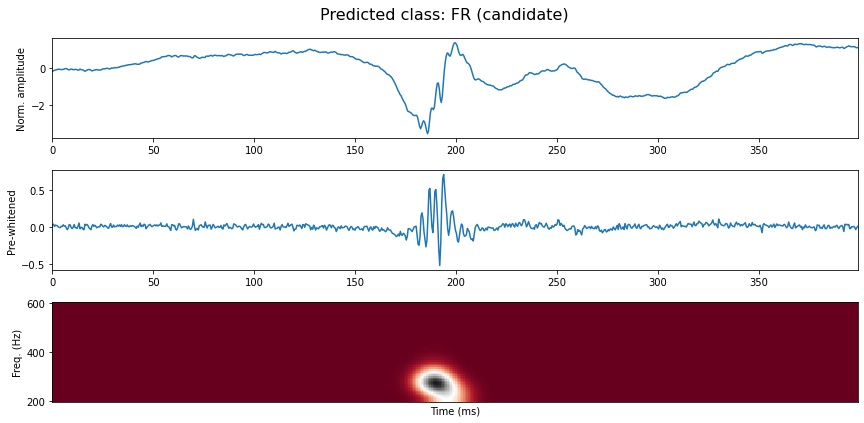

In [8]:
#==============================================#
#                                              #
#   User SHOULD NOT change these parameters    #
#                                              #
#==============================================#

### List all files (timeseries) in folder
file_names_in_folder = os.listdir(os.path.join(events_folderpath, f"EEG-{event_scale_to_plot}-{event_type_to_plot}/events_signal_data"))
file_names = [fname for fname in file_names_in_folder if ".txt" in fname]
print(f"{event_scale_to_plot}-{event_type_to_plot}: ", file_names)

### Load meta-data
json_filepath = os.path.join(events_folderpath, f"EEG-{event_scale_to_plot}-{event_type_to_plot}/events_info.json")
json_dict = json.load(open(json_filepath))
current_sfreq = json_dict["events_info"][event_num]["sampling_frequency"]

### Get event file name
current_sfreq = json_dict["events_info"][event_num]["sampling_frequency"]
file_name_to_plot = f"event_{json_dict['events_info'][event_num]['ID']}.txt"

### Load one timeseries
timeseries_filepath = os.path.join(events_folderpath, f"EEG-{event_scale_to_plot}-{event_type_to_plot}/events_signal_data/{file_name_to_plot}")
timeseries = load_one_timeseries(timeseries_filepath)

### Standardize timeseries
standardized_timeseries = standardize_timeseries(timeseries)

### Whiten timeseries
whitened_timeseries = whiten_timeseries(standardized_timeseries)

### Create, whiten and convolve scalogram
scalogram = Calc_scalogram(
    whitened_timeseries, bp_filter, current_sfreq, nf=50, 
    whiten_ZH0=True, apply_convolution=True)

### Predict scalogram
pred, pred_class = predict_one_scalogram(model,
    scalogram.scalogram_dict["scalogram"])

### Plot data
plot_one_event(standardized_timeseries, whitened_timeseries, scalogram.scalogram_dict["x_cwt"], scalogram.scalogram_dict["y_cwt"], scalogram.scalogram_dict["scalogram"], pred_class, current_sfreq)


## 3.3. Apply detection for all event categories

The database we provide consists of several categories. Let us see what happens when we apply our method to all of them. The figures will be plotted for 10 examples per category (not 20) in order to reduce the size of this document. Nevertheless, user should feel free to plot the others. The event categories are as follow:
- macro-FR (x20)
- macro-nonFR (x20)
- micro-FR (x20)
- micro-nonFR (x20)

In [9]:
#=============================================#
#                                             #
#   User SHOULD NOT change these parameters   #
#                                             #
#=============================================#

def plot_events(event_scale_to_plot, event_type_to_plot):

    print("")
    print(f"{event_scale_to_plot} {event_type_to_plot}")
    print("-------------")

    ### List all files (timeseries) in folder
    file_names_in_folder = os.listdir(os.path.join(events_folderpath, f"EEG-{event_scale_to_plot}-{event_type_to_plot}/events_signal_data"))
    file_names = [fname for fname in file_names_in_folder if ".txt" in fname]
    print(file_names)
    print()

    ### Load meta-data
    json_filepath = os.path.join(events_folderpath, f"EEG-{event_scale_to_plot}-{event_type_to_plot}/events_info.json")
    json_dict = json.load(open(json_filepath))                        

    ### Loop over all events of a given category (ex: macro-FR or micro-nonFR)
    n_good_predict = 0
    n_err = 0       

    for event_num in range(0,len(json_dict["events_info"])):

        ### Get event file name
        current_sfreq = json_dict["events_info"][event_num]["sampling_frequency"]
        file_name_to_plot = f"event_{json_dict['events_info'][event_num]['ID']}.txt"

        ### Load one timeseries
        timeseries_filepath = os.path.join(events_folderpath, f"EEG-{event_scale_to_plot}-{event_type_to_plot}/events_signal_data/{file_name_to_plot}")
        timeseries = load_one_timeseries(timeseries_filepath)

        ### Standardize timeseries
        standardized_timeseries = standardize_timeseries(timeseries)

        ### Whiten timeseries
        whitened_timeseries = whiten_timeseries(standardized_timeseries)

        ### Create, whiten and convolve scalogram
        scalogram = Calc_scalogram(
            whitened_timeseries, bp_filter, current_sfreq, nf=50, 
            whiten_ZH0=True, apply_convolution=True)

        ### Predict scalogram
        pred, pred_class = predict_one_scalogram(model,
            scalogram.scalogram_dict["scalogram"])

        ### Print result
        print("")
        if event_type_to_plot == "FR":
            if "FR" in pred_class:
                print(f"Result {event_num+1}/{len(json_dict['events_info'])} ({file_name_to_plot}): True positive (Real: {event_type_to_plot} / Predicted: {pred_class})")
                n_good_predict+=1
                res = "True positive"
            else:
                print(f"Result {event_num+1}/{len(json_dict['events_info'])} ({file_name_to_plot}): False negative (Real: {event_type_to_plot} / Predicted: {pred_class})")
                n_err+=1
                res = "False negative"

        if event_type_to_plot == "nonFR":
            if "Other" in pred_class:
                print(f"Result {event_num+1}/{len(json_dict['events_info'])} ({file_name_to_plot}): True negative (Real: {event_type_to_plot} / Predicted: {pred_class})")
                n_good_predict+=1
                res = "True negative"
            else:
                print(f"Result {event_num+1}/{len(json_dict['events_info'])} ({file_name_to_plot}): False positive (Real : {event_type_to_plot} / Predicted: {pred_class})")
                n_err+=1
                res = "False positive"

        if event_num < 10:
            plot_one_event(standardized_timeseries, whitened_timeseries, scalogram.scalogram_dict["x_cwt"], scalogram.scalogram_dict["y_cwt"], scalogram.scalogram_dict["scalogram"], f"{pred_class} --> {res}", current_sfreq)

    print("...")
    print(f"N good predictions: {n_good_predict}") 
    print(f"N errors: {n_err}")
    print("...")

### 3.3.1. Macro-FR


macro FR
-------------
['event_703.txt', 'event_649.txt', 'event_648.txt', 'event_371.txt', 'event_978.txt', 'event_97.txt', 'event_805.txt', 'event_418.txt', 'event_196.txt', 'event_433.txt', 'event_194.txt', 'event_79.txt', 'event_585.txt', 'event_778.txt', 'event_643.txt', 'event_509.txt', 'event_508.txt', 'event_642.txt', 'event_907.txt']


Result 1/19 (event_79.txt): True positive (Real: FR / Predicted: FR (candidate))


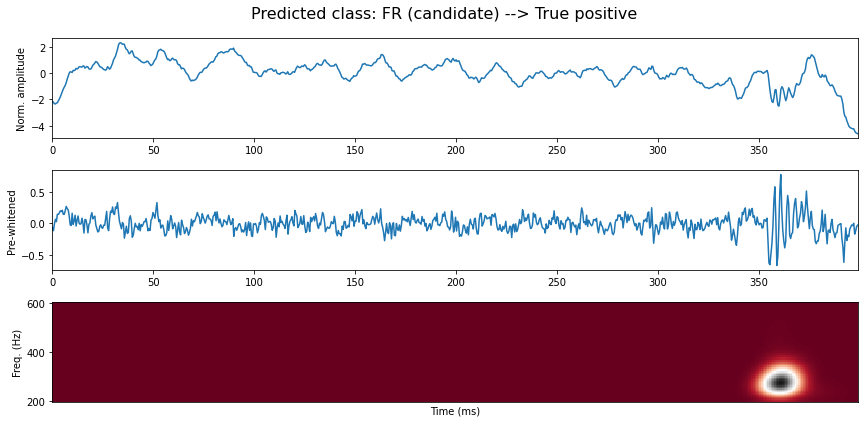


Result 2/19 (event_97.txt): True positive (Real: FR / Predicted: FR (candidate))


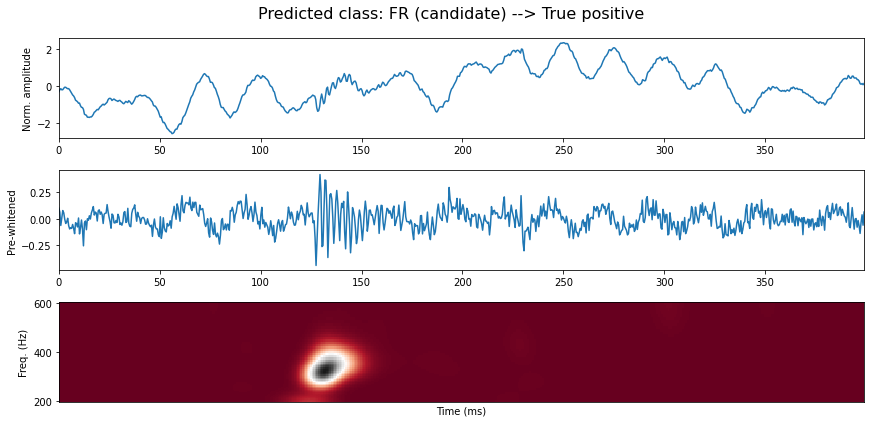


Result 3/19 (event_194.txt): True positive (Real: FR / Predicted: FR (candidate))


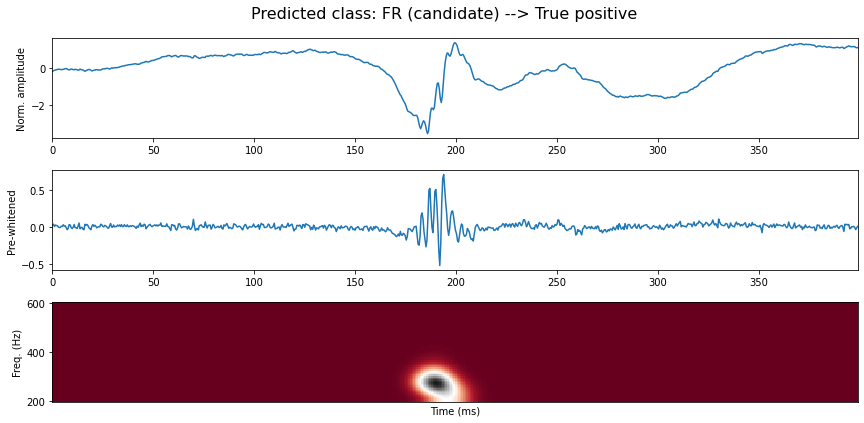


Result 4/19 (event_196.txt): True positive (Real: FR / Predicted: FR (candidate))


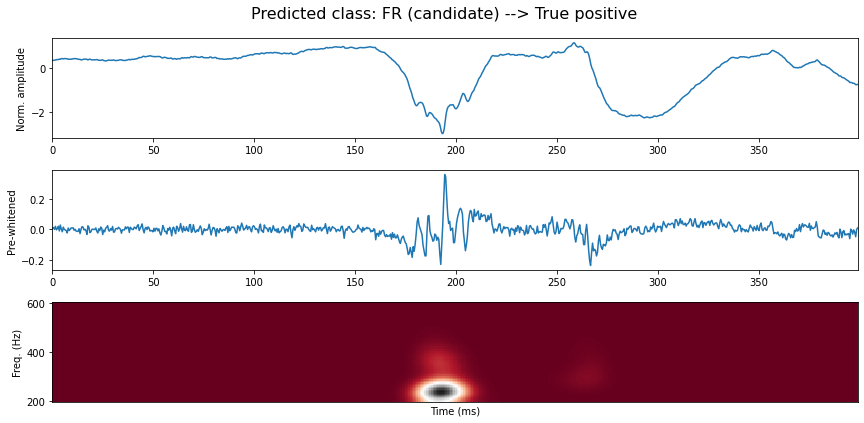


Result 5/19 (event_371.txt): True positive (Real: FR / Predicted: FR (candidate))


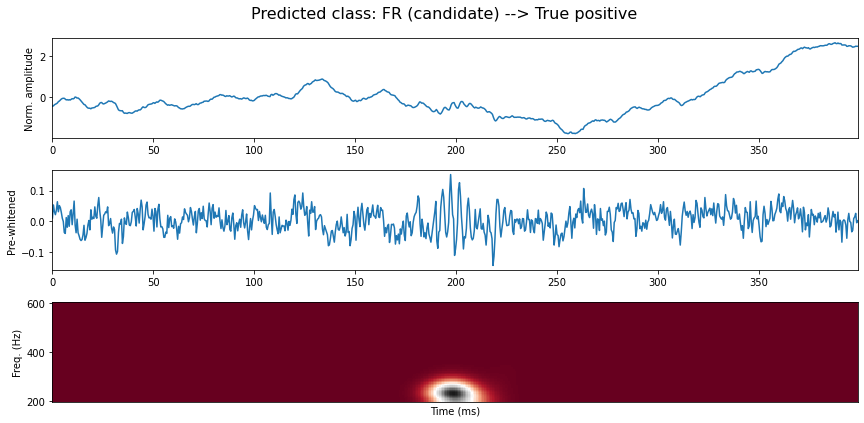


Result 6/19 (event_418.txt): True positive (Real: FR / Predicted: FR (candidate))


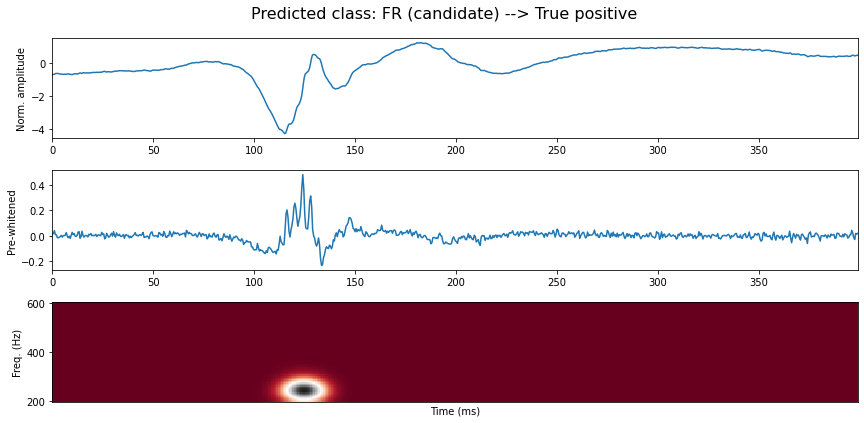


Result 7/19 (event_433.txt): True positive (Real: FR / Predicted: FR (candidate))


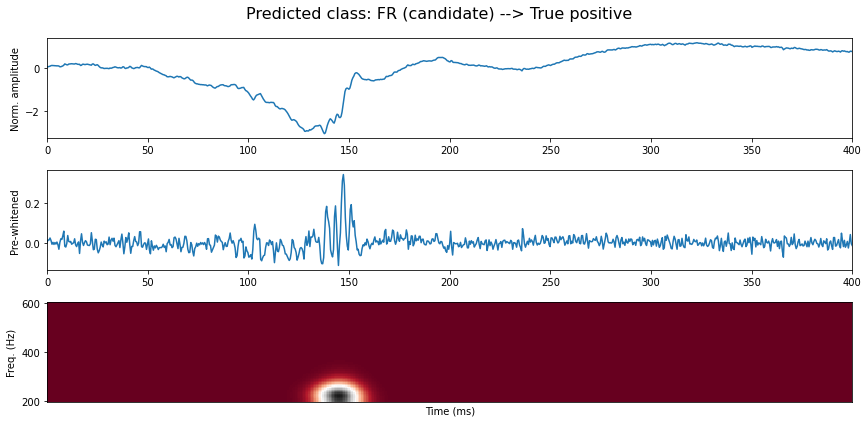


Result 8/19 (event_508.txt): True positive (Real: FR / Predicted: FR (candidate))


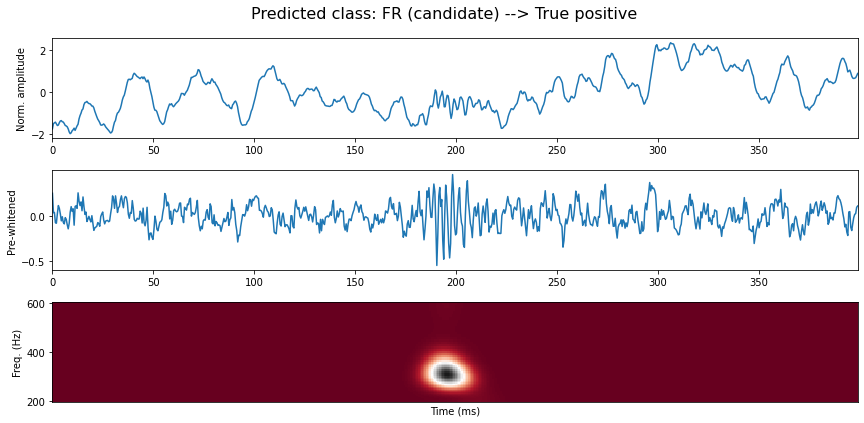


Result 9/19 (event_509.txt): True positive (Real: FR / Predicted: FR (candidate))


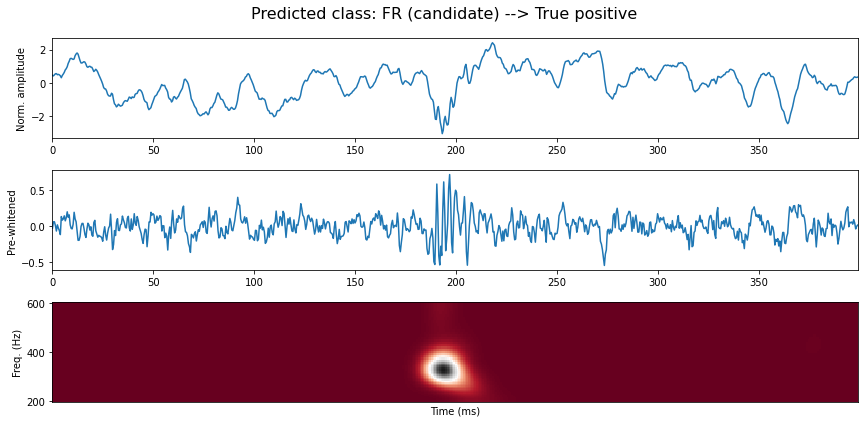


Result 10/19 (event_585.txt): True positive (Real: FR / Predicted: FR (candidate))


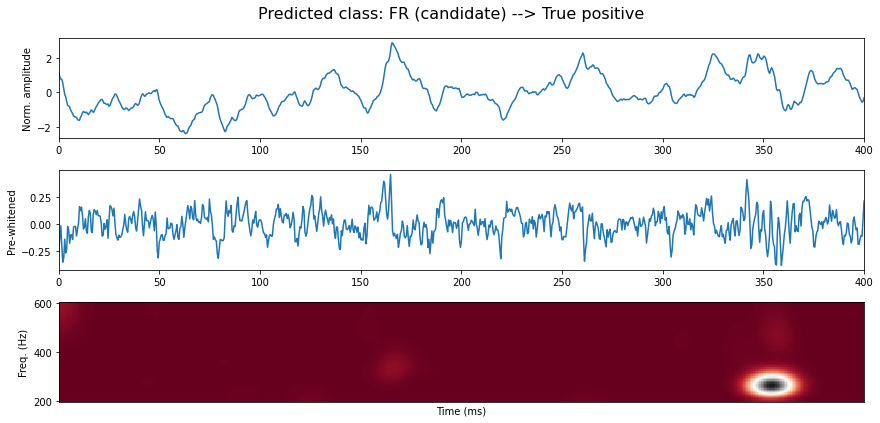


Result 11/19 (event_642.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 12/19 (event_643.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 13/19 (event_648.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 14/19 (event_649.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 15/19 (event_703.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 16/19 (event_778.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 17/19 (event_805.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 18/19 (event_907.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 19/19 (event_978.txt): True positive (Real: FR / Predicted: FR (candidate))
...
N good predictions: 19
N errors: 0
...


In [10]:
event_scale_to_plot = "macro"
event_type_to_plot = "FR"
plot_events(event_scale_to_plot, event_type_to_plot)

### 3.3.2. Micro-FR


micro FR
-------------
['event_5304.txt', 'event_211.txt', 'event_212.txt', 'event_5174.txt', 'event_217.txt', 'event_5213.txt', 'event_214.txt', 'event_229.txt', 'event_146.txt', 'event_230.txt', 'event_231.txt', 'event_219.txt', 'event_5222.txt', 'event_233.txt', 'event_144.txt', 'event_140.txt', 'event_223.txt', 'event_5146.txt', 'event_220.txt']


Result 1/19 (event_140.txt): True positive (Real: FR / Predicted: FR (candidate))


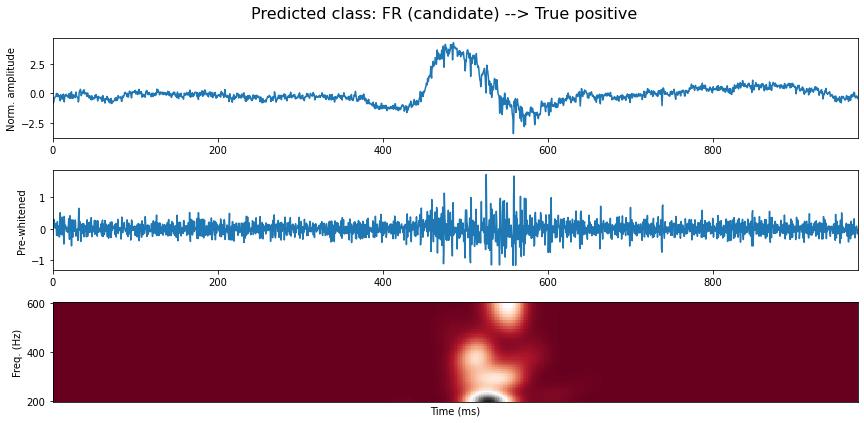


Result 2/19 (event_144.txt): True positive (Real: FR / Predicted: FR (candidate))


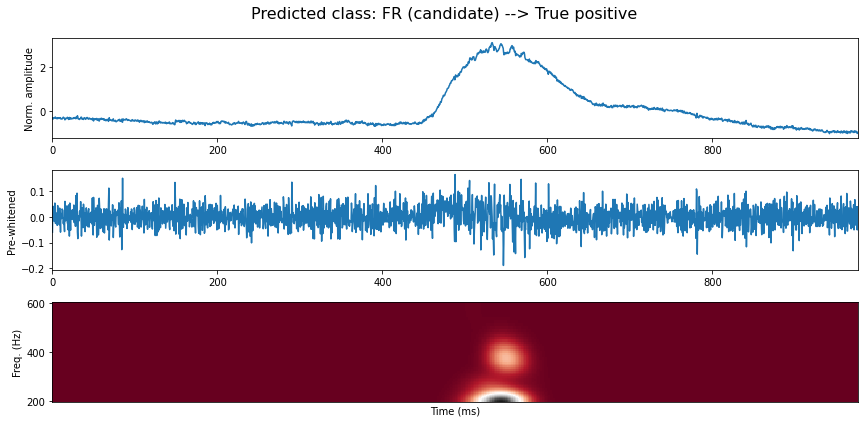


Result 3/19 (event_146.txt): True positive (Real: FR / Predicted: FR (candidate))


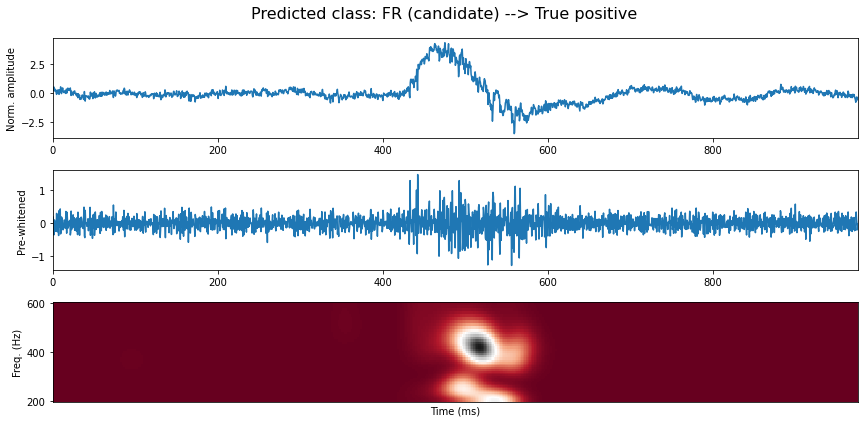


Result 4/19 (event_211.txt): True positive (Real: FR / Predicted: FR (candidate))


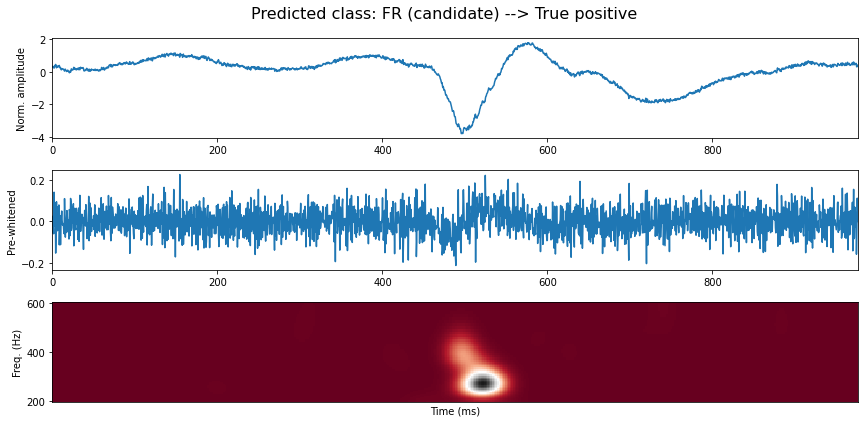


Result 5/19 (event_212.txt): True positive (Real: FR / Predicted: FR (candidate))


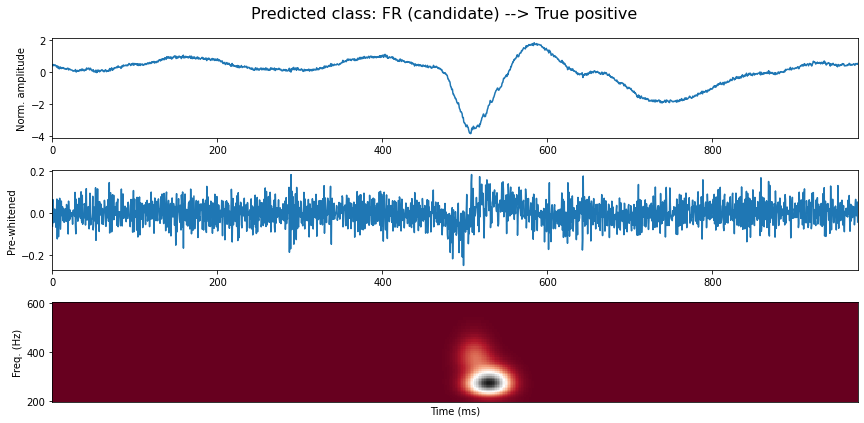


Result 6/19 (event_214.txt): True positive (Real: FR / Predicted: FR (candidate))


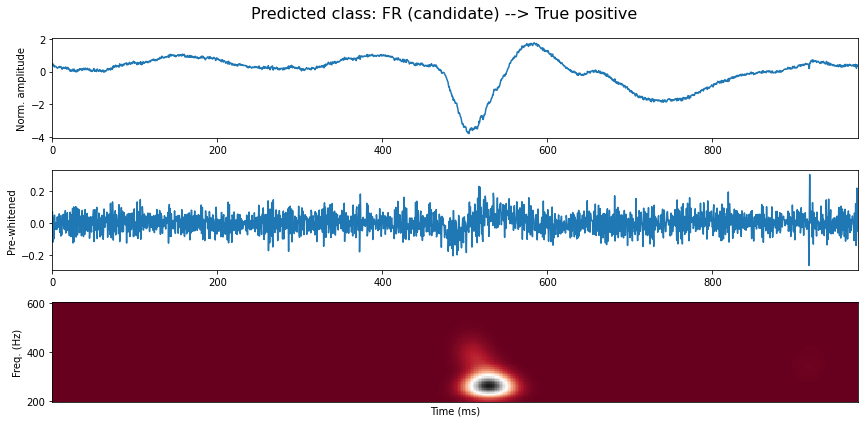


Result 7/19 (event_217.txt): True positive (Real: FR / Predicted: FR (candidate))


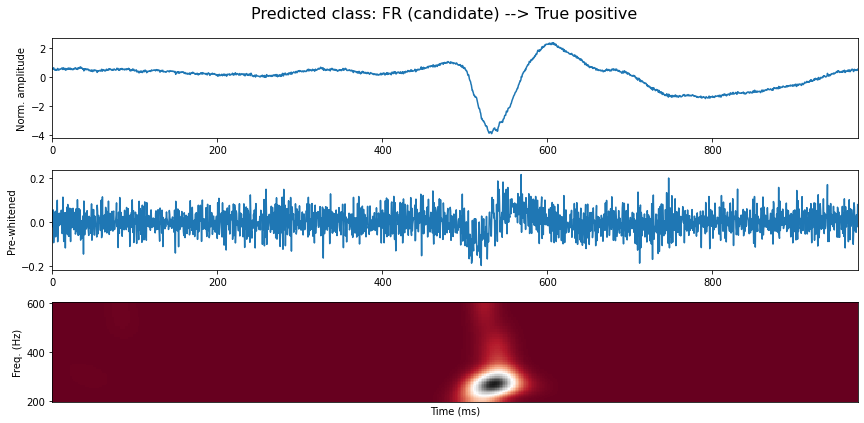


Result 8/19 (event_219.txt): True positive (Real: FR / Predicted: FR (candidate))


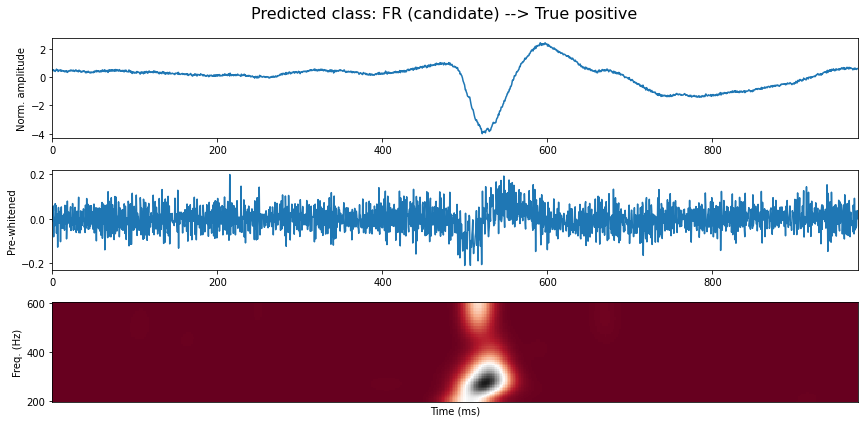


Result 9/19 (event_220.txt): True positive (Real: FR / Predicted: FR (candidate))


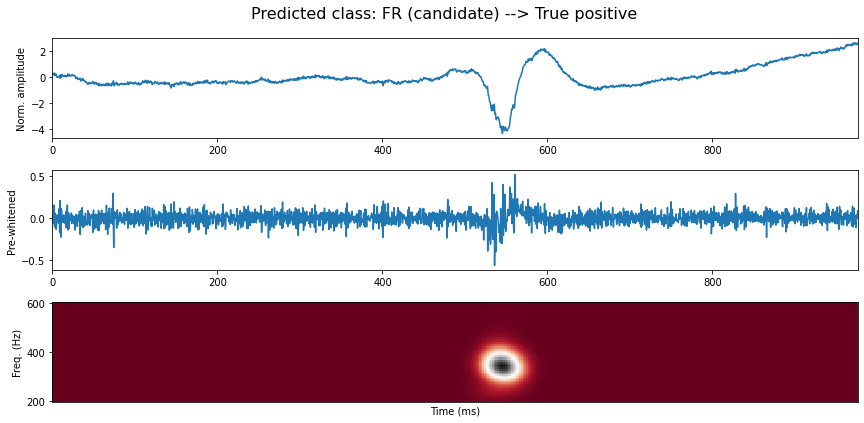


Result 10/19 (event_223.txt): True positive (Real: FR / Predicted: FR (candidate))


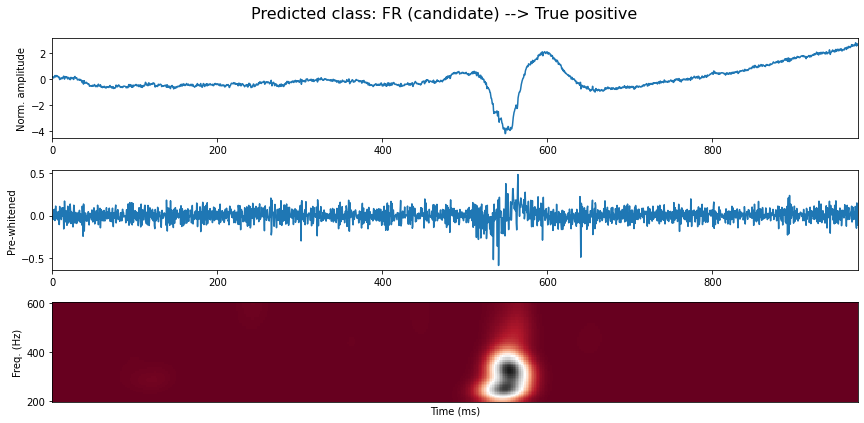


Result 11/19 (event_229.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 12/19 (event_230.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 13/19 (event_231.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 14/19 (event_233.txt): False negative (Real: FR / Predicted: Other)

Result 15/19 (event_5146.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 16/19 (event_5174.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 17/19 (event_5213.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 18/19 (event_5222.txt): True positive (Real: FR / Predicted: FR (candidate))

Result 19/19 (event_5304.txt): True positive (Real: FR / Predicted: FR (candidate))
...
N good predictions: 18
N errors: 1
...


In [11]:
event_scale_to_plot = "micro"
event_type_to_plot = "FR"
plot_events(event_scale_to_plot, event_type_to_plot)

### 3.3.3. Macro-nonFR


macro nonFR
-------------
['event_4888.txt', 'event_4889.txt', 'event_4881.txt', 'event_4895.txt', 'event_4894.txt', 'event_4880.txt', 'event_4896.txt', 'event_4882.txt', 'event_4883.txt', 'event_4893.txt', 'event_4887.txt', 'event_4878.txt', 'event_4879.txt', 'event_4886.txt', 'event_4892.txt', 'event_4884.txt', 'event_4890.txt', 'event_4891.txt', 'event_4885.txt']


Result 1/19 (event_4878.txt): True negative (Real: nonFR / Predicted: Other)


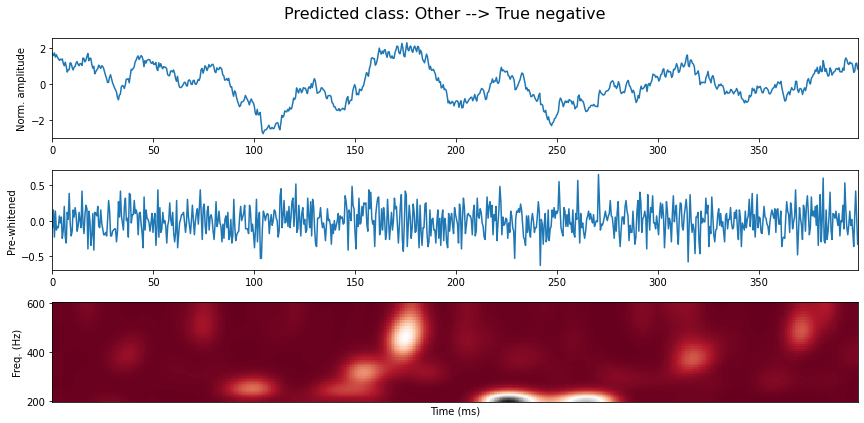


Result 2/19 (event_4879.txt): True negative (Real: nonFR / Predicted: Other)


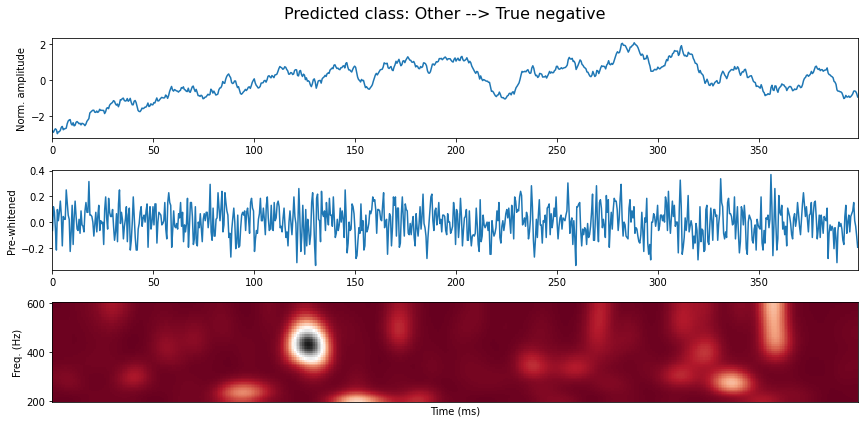


Result 3/19 (event_4880.txt): True negative (Real: nonFR / Predicted: Other)


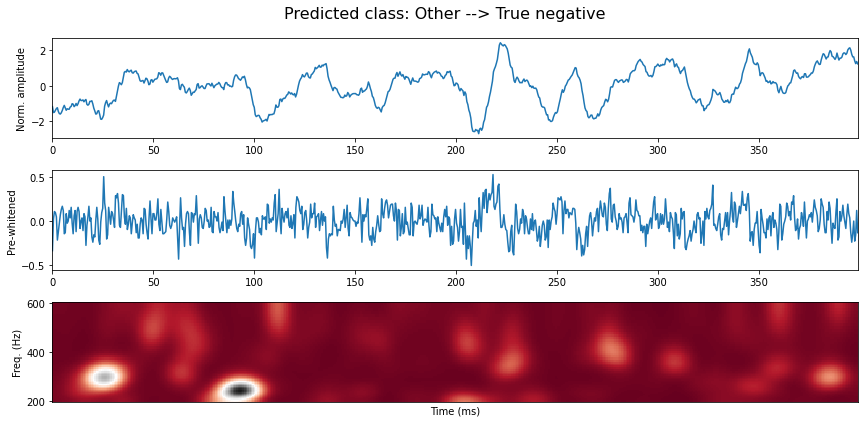


Result 4/19 (event_4881.txt): True negative (Real: nonFR / Predicted: Other)


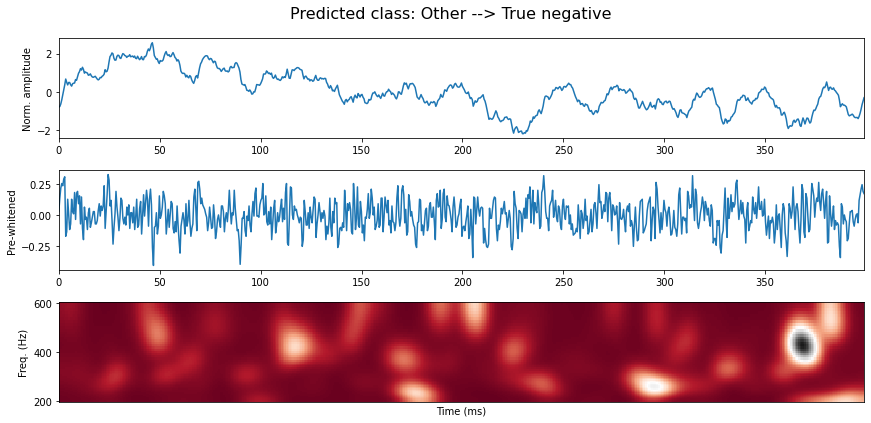


Result 5/19 (event_4882.txt): True negative (Real: nonFR / Predicted: Other)


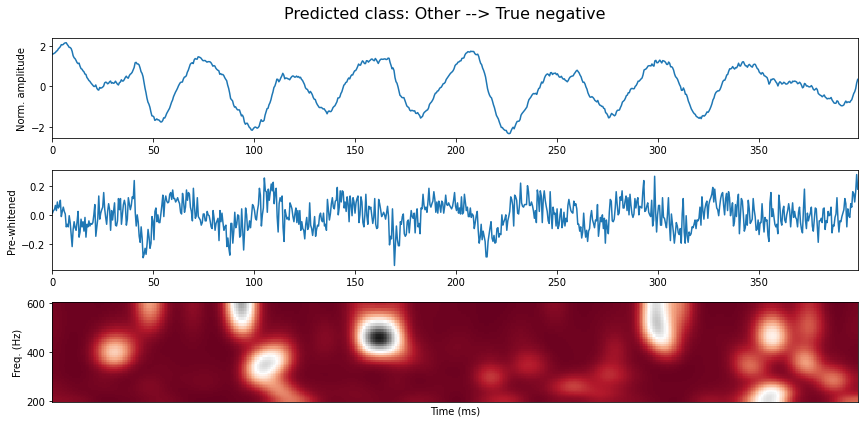


Result 6/19 (event_4883.txt): True negative (Real: nonFR / Predicted: Other)


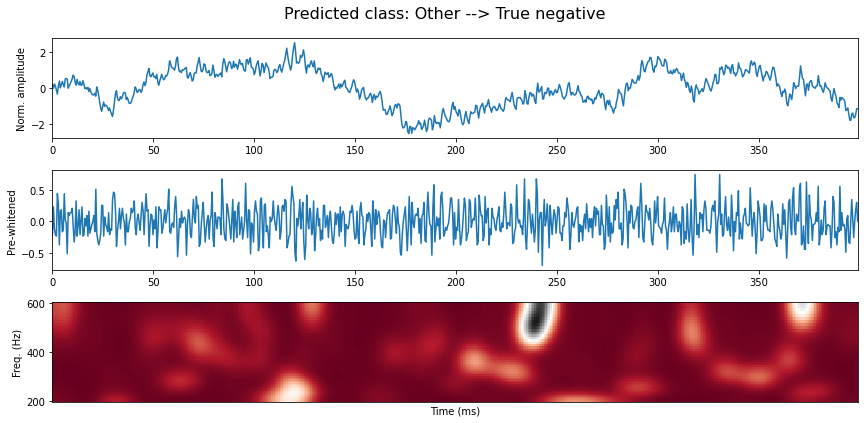


Result 7/19 (event_4884.txt): True negative (Real: nonFR / Predicted: Other)


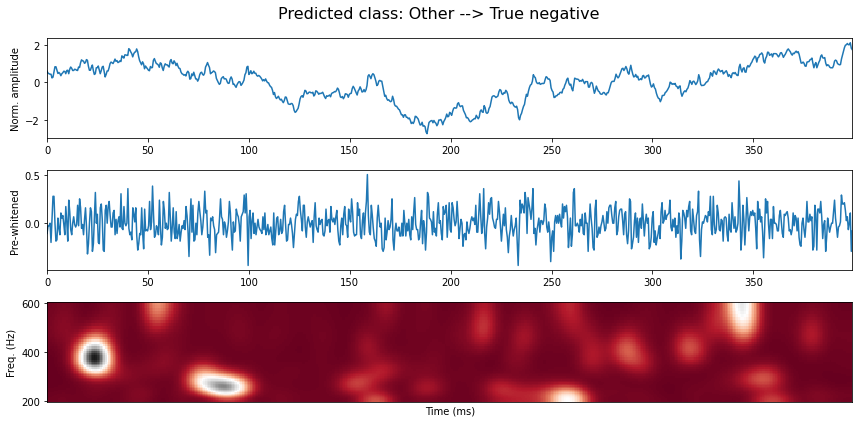


Result 8/19 (event_4885.txt): True negative (Real: nonFR / Predicted: Other)


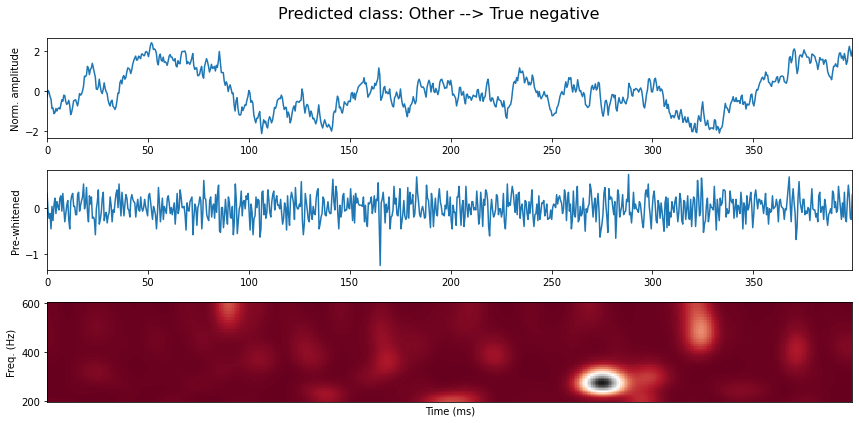


Result 9/19 (event_4886.txt): True negative (Real: nonFR / Predicted: Other)


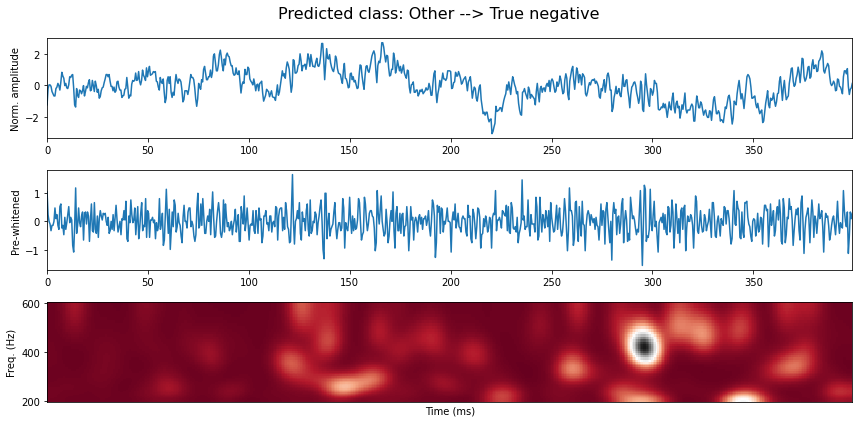


Result 10/19 (event_4887.txt): True negative (Real: nonFR / Predicted: Other)


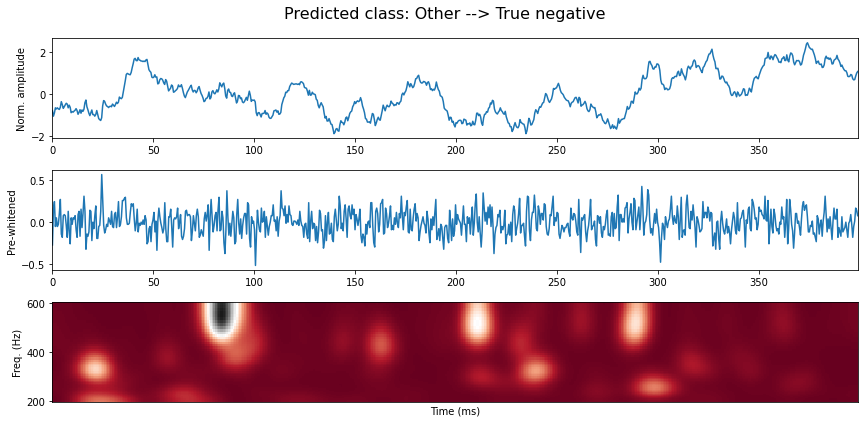


Result 11/19 (event_4888.txt): True negative (Real: nonFR / Predicted: Other)

Result 12/19 (event_4889.txt): True negative (Real: nonFR / Predicted: Other)

Result 13/19 (event_4890.txt): True negative (Real: nonFR / Predicted: Other)

Result 14/19 (event_4891.txt): True negative (Real: nonFR / Predicted: Other)

Result 15/19 (event_4892.txt): True negative (Real: nonFR / Predicted: Other)

Result 16/19 (event_4893.txt): True negative (Real: nonFR / Predicted: Other)

Result 17/19 (event_4894.txt): True negative (Real: nonFR / Predicted: Other)

Result 18/19 (event_4895.txt): True negative (Real: nonFR / Predicted: Other)

Result 19/19 (event_4896.txt): True negative (Real: nonFR / Predicted: Other)
...
N good predictions: 19
N errors: 0
...


In [12]:
event_scale_to_plot = "macro"
event_type_to_plot = "nonFR"
plot_events(event_scale_to_plot, event_type_to_plot)

### 3.3.4. Micro-nonFR


micro nonFR
-------------
['event_110.txt', 'event_104.txt', 'event_105.txt', 'event_111.txt', 'event_107.txt', 'event_112.txt', 'event_106.txt', 'event_102.txt', 'event_103.txt', 'event_101.txt', 'event_100.txt', 'event_98.txt', 'event_99.txt', 'event_97.txt', 'event_96.txt', 'event_95.txt', 'event_93.txt', 'event_108.txt', 'event_109.txt']


Result 1/19 (event_93.txt): True negative (Real: nonFR / Predicted: Other)


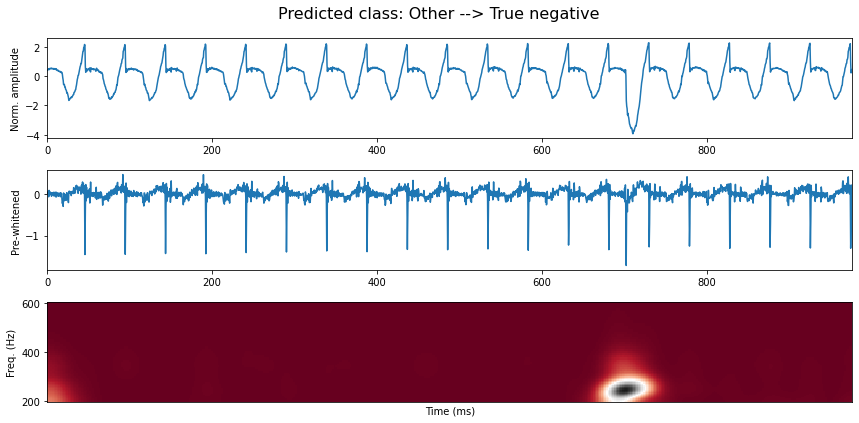


Result 2/19 (event_95.txt): True negative (Real: nonFR / Predicted: Other)


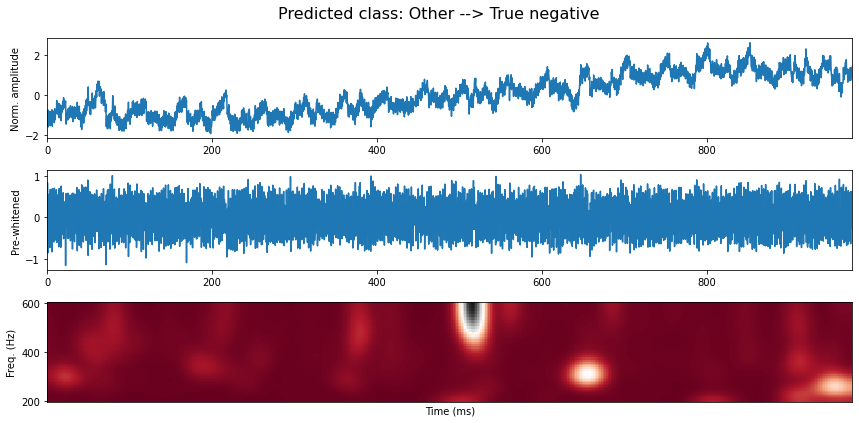


Result 3/19 (event_96.txt): True negative (Real: nonFR / Predicted: Other)


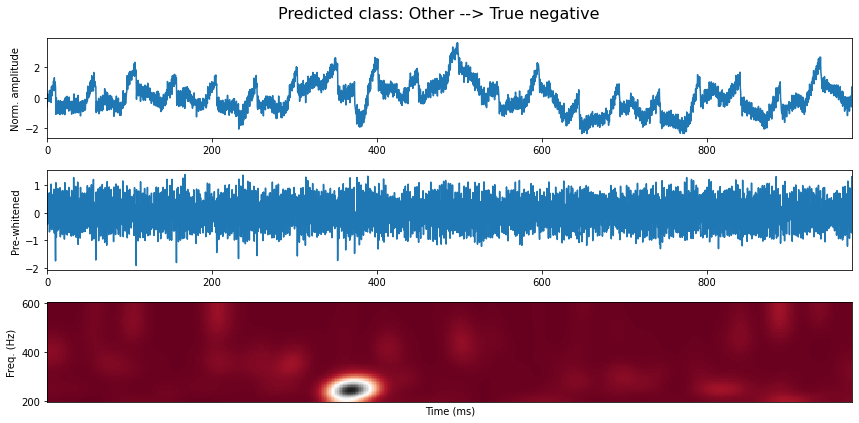


Result 4/19 (event_97.txt): True negative (Real: nonFR / Predicted: Other)


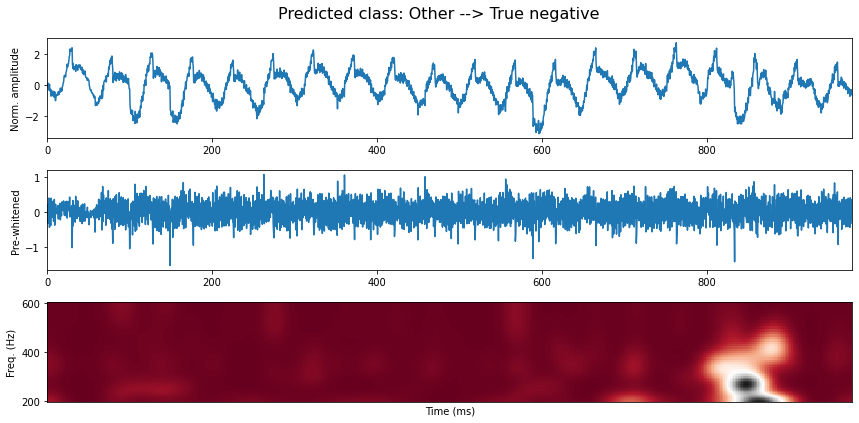


Result 5/19 (event_98.txt): True negative (Real: nonFR / Predicted: Other)


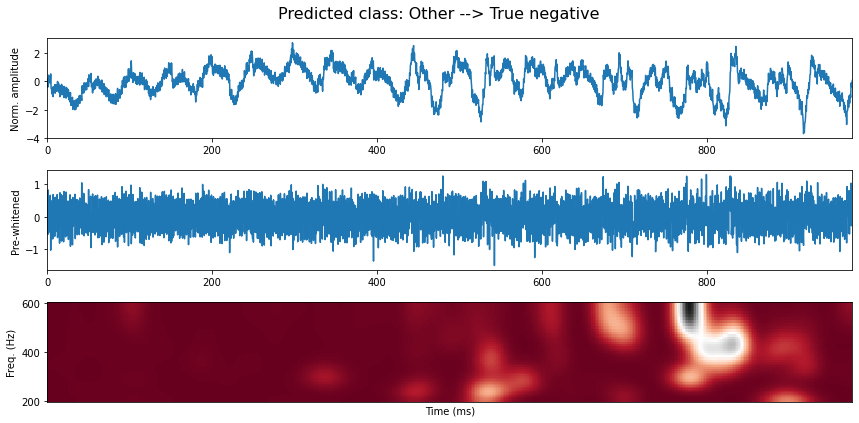


Result 6/19 (event_99.txt): False positive (Real : nonFR / Predicted: FR (candidate))


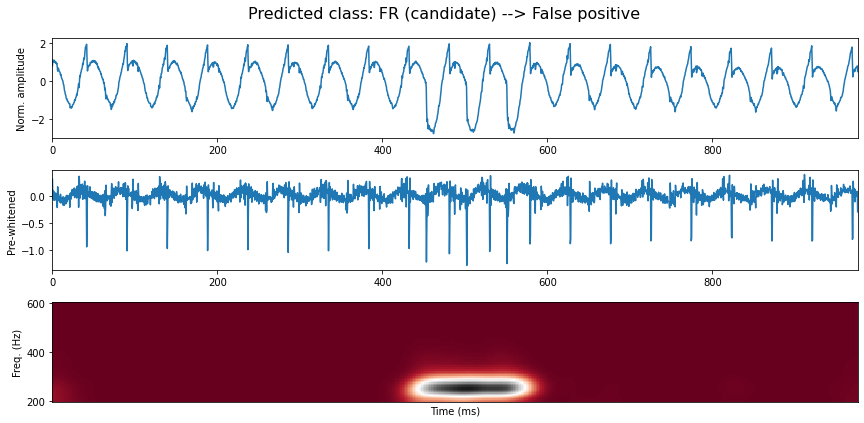


Result 7/19 (event_100.txt): True negative (Real: nonFR / Predicted: Other)


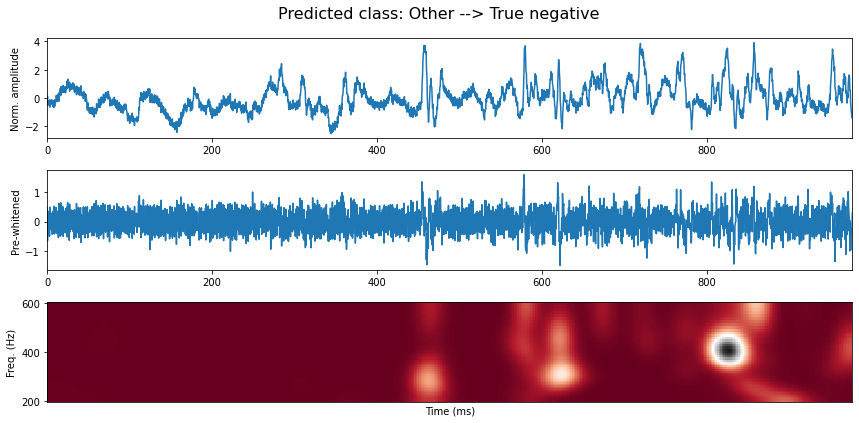


Result 8/19 (event_101.txt): True negative (Real: nonFR / Predicted: Other)


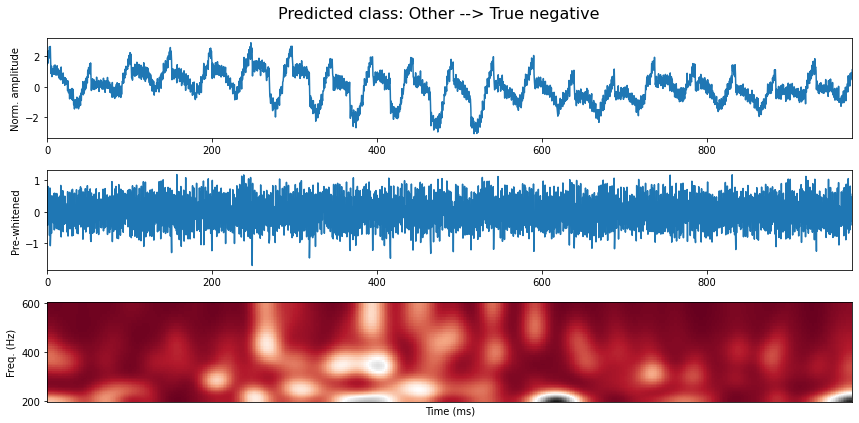


Result 9/19 (event_102.txt): True negative (Real: nonFR / Predicted: Other)


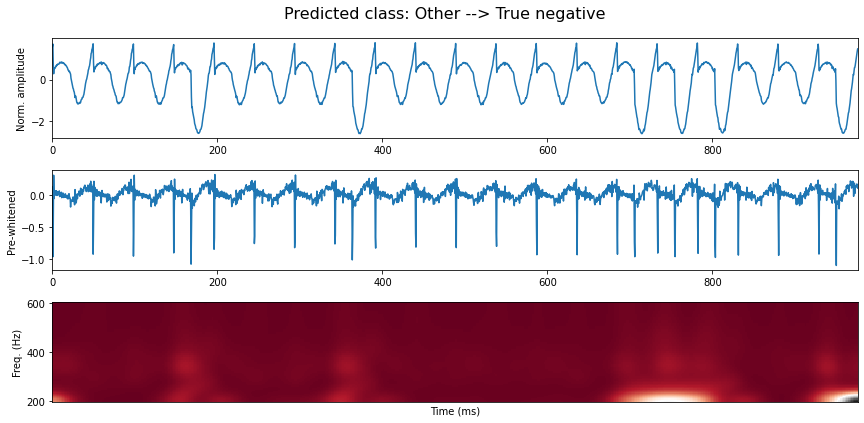


Result 10/19 (event_103.txt): True negative (Real: nonFR / Predicted: Other)


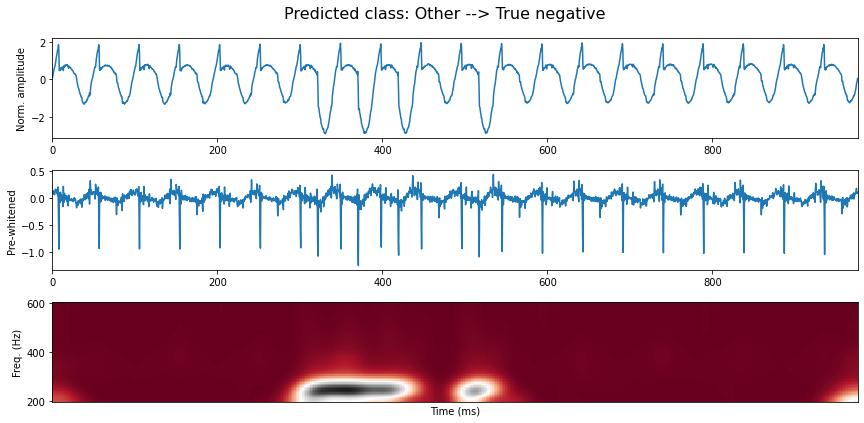


Result 11/19 (event_104.txt): True negative (Real: nonFR / Predicted: Other)

Result 12/19 (event_105.txt): True negative (Real: nonFR / Predicted: Other)

Result 13/19 (event_106.txt): True negative (Real: nonFR / Predicted: Other)

Result 14/19 (event_107.txt): True negative (Real: nonFR / Predicted: Other)

Result 15/19 (event_108.txt): True negative (Real: nonFR / Predicted: Other)

Result 16/19 (event_109.txt): True negative (Real: nonFR / Predicted: Other)

Result 17/19 (event_110.txt): True negative (Real: nonFR / Predicted: Other)

Result 18/19 (event_111.txt): True negative (Real: nonFR / Predicted: Other)

Result 19/19 (event_112.txt): True negative (Real: nonFR / Predicted: Other)
...
N good predictions: 18
N errors: 1
...


In [13]:
event_scale_to_plot = "micro"
event_type_to_plot = "nonFR"
plot_events(event_scale_to_plot, event_type_to_plot)

# 4. Resiliency testing

Now that we have evaluated our normalization and detection procedures on real data, at multiple scales, let's proceed to some tests on simulated data, whose frequency and content are known. This evaluation allows us to verify that the detected signals meet the desired criteria.

Note that :
- The effect of the simulations can cause artifacts on the scalogram, due to the abrupt changes in frequency. Despite these artifacts, the detector makes the correct prediction, without getting trapped.
- To eliminate filtering artifacts, the edges of the image are cut off. This can cause a shift (visually) on the x-axis, blobs that reflect high frequencies, when a FR is present for example.

We have a database of more than 400 epileptic spikes without FR that we can make available, on which we have successfully performed the same tests. Our automatic detector does not retain them, whatever their morphology or intensity.

['event_16.txt', 'event_17.txt', 'event_15.txt', 'event_14.txt', 'event_10.txt', 'event_11.txt', 'event_13.txt', 'event_12.txt', 'event_8.txt', 'event_9.txt', 'event_1.txt', 'event_2.txt', 'event_3.txt', 'event_7.txt', 'event_6.txt', 'event_4.txt', 'event_5.txt', 'event_20.txt', 'event_19.txt', 'event_18.txt']

Event 1 meta data
-------------------
ID: 1
type: FR simul-9
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: freq = 250; numcycles = 9


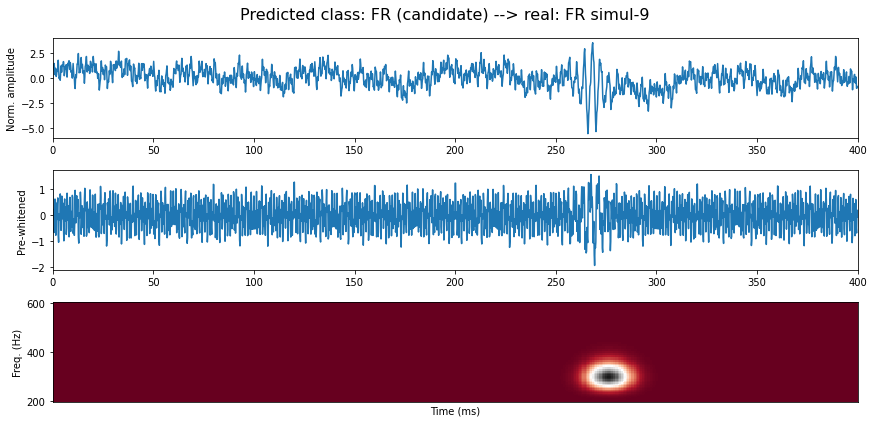





Event 2 meta data
-------------------
ID: 2
type: Transient simul
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test


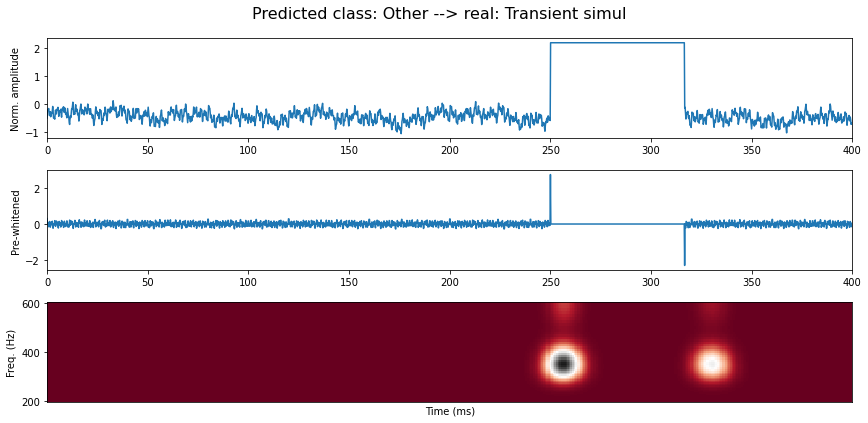





Event 3 meta data
-------------------
ID: 3
type: FR simul-20
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: freq = 300; numcycles = 20


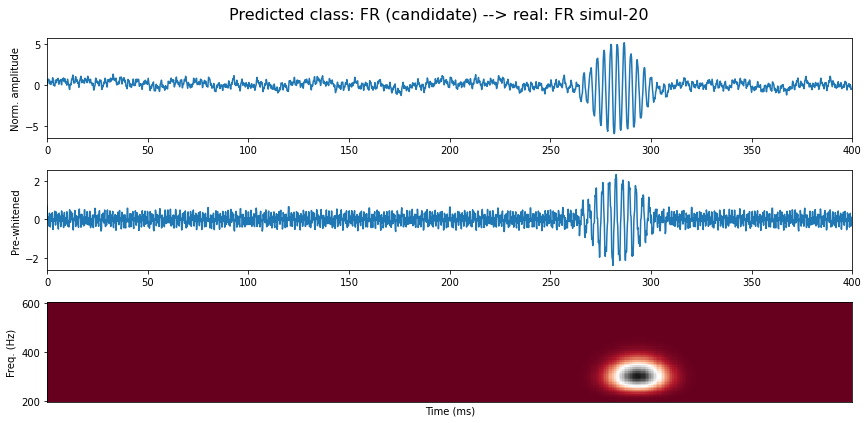





Event 4 meta data
-------------------
ID: 4
type: Spk-alone
patient_num: 02
chan_type: macro
chan_name: of1-of2
sampling_frequency: 2048
eventTime_inFilename_(s): 401.2
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: sub-002_ses-MacroBipolar01_task-EPIFAR_run-01_ieeg.edf
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test


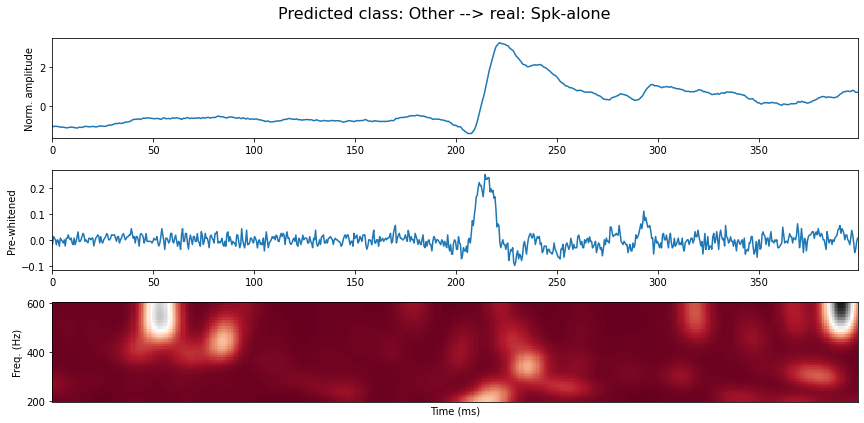





Event 5 meta data
-------------------
ID: 5
type: Spk-alone
patient_num: 02
chan_type: macro
chan_name: of2-of3
sampling_frequency: 2048
eventTime_inFilename_(s): 401.2
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: sub-002_ses-MacroBipolar01_task-EPIFAR_run-01_ieeg.edf
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test


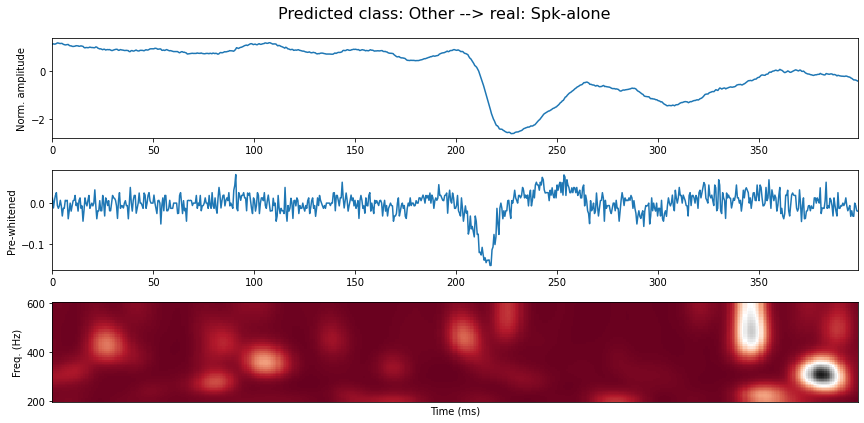





Event 6 meta data
-------------------
ID: 6
type: Spk-alone
patient_num: 02
chan_type: macro
chan_name: op3-op4
sampling_frequency: 2048
eventTime_inFilename_(s): 503.6
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: sub-002_ses-MacroBipolar01_task-EPIFAR_run-01_ieeg.edf
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test


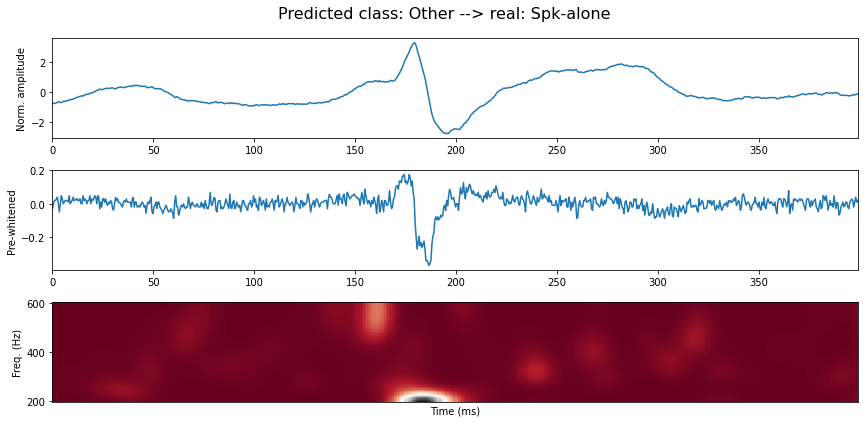





Event 7 meta data
-------------------
ID: 7
type: Spk-alone
patient_num: 02
chan_type: macro
chan_name: of1-of2
sampling_frequency: 2048
eventTime_inFilename_(s): 503.6
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: sub-002_ses-MacroBipolar01_task-EPIFAR_run-01_ieeg.edf
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test


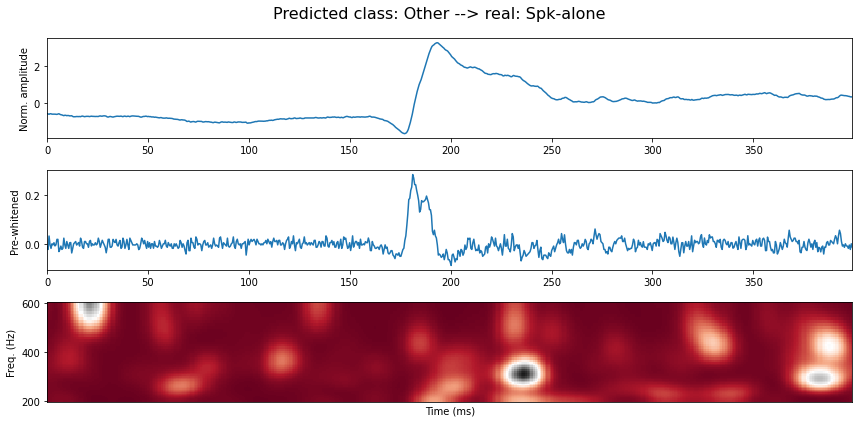





Event 8 meta data
-------------------
ID: 8
type: Spk-alone
patient_num: 02
chan_type: macro
chan_name: of2-of3
sampling_frequency: 2048
eventTime_inFilename_(s): 503.6
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: sub-002_ses-MacroBipolar01_task-EPIFAR_run-01_ieeg.edf
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test


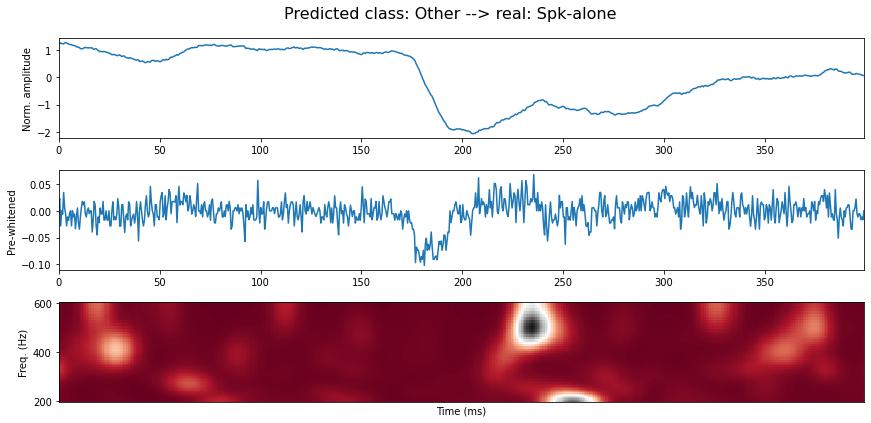





Event 9 meta data
-------------------
ID: 9
type: Spk-alone
patient_num: 02
chan_type: macro
chan_name: op3-op4
sampling_frequency: 2048
eventTime_inFilename_(s): 505.5
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: sub-002_ses-MacroBipolar01_task-EPIFAR_run-01_ieeg.edf
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test


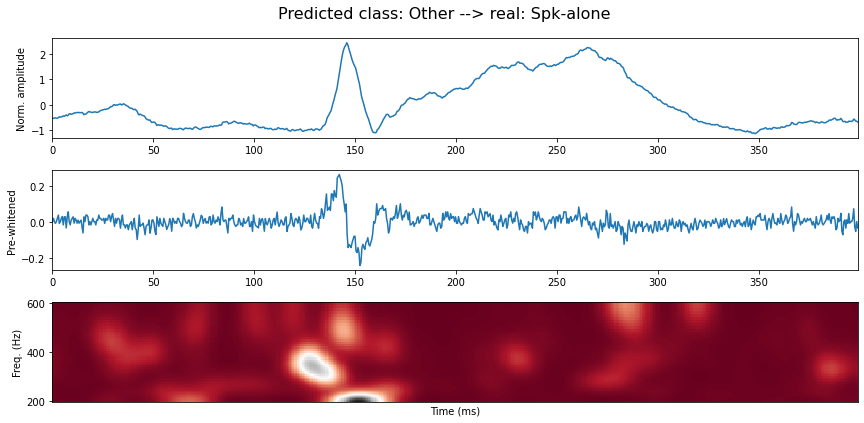





Event 10 meta data
-------------------
ID: 10
type: [A] Spk-alone
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Noise: [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0, 250.0, 425.0, 500.0, 800.0, 1500.0]


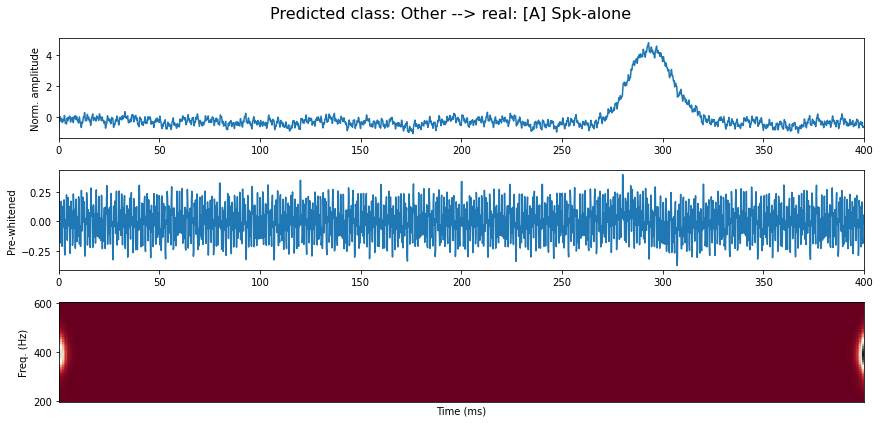





Event 11 meta data
-------------------
ID: 11
type: [A] FR
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: freq = 250; numcycles = 12; spike_sig x 100; FR_sig x 10
Noise: [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0, 250.0, 425.0, 500.0, 800.0, 1500.0]


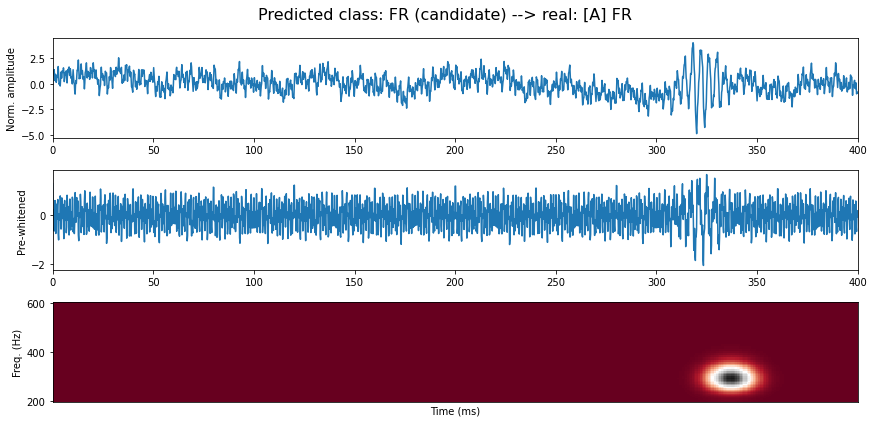





Event 12 meta data
-------------------
ID: 12
type: [A] Spk-FR
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: simul:1000; spike_sig x 100; FR_sig x 10
Noise: [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0, 250.0, 425.0, 500.0, 800.0, 1500.0]


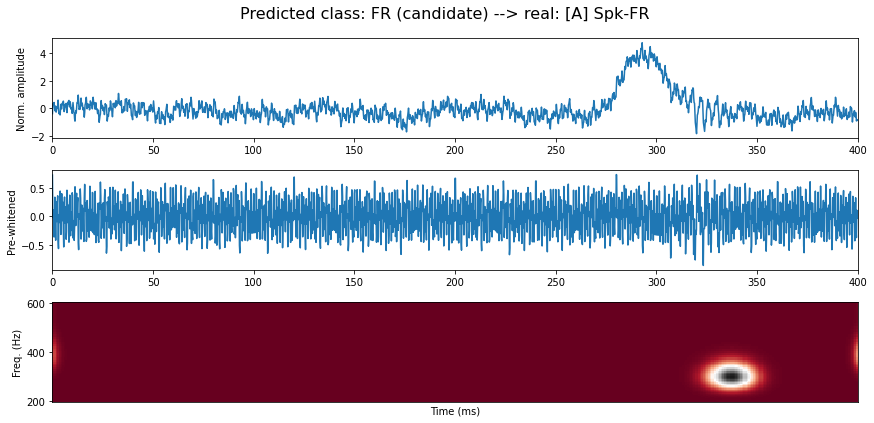





Event 13 meta data
-------------------
ID: 13
type: [B] Spk-alone
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: simul:1000; spike_sig x 100
Noise: [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0, 250.0, 425.0, 500.0, 800.0, 1500.0]


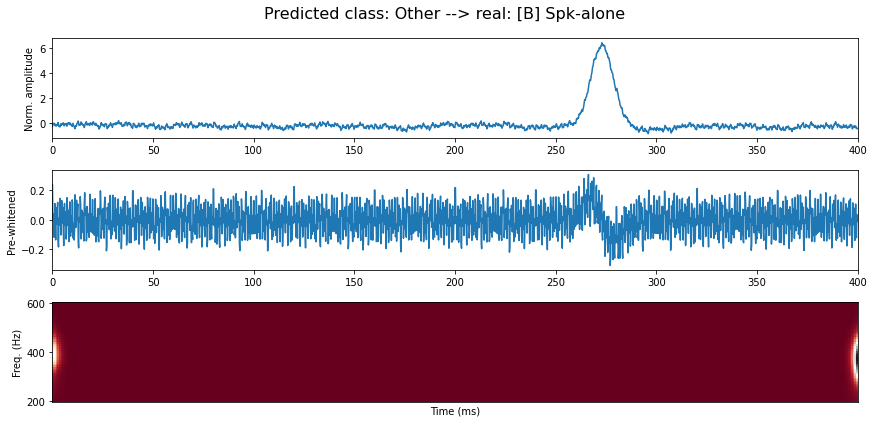





Event 14 meta data
-------------------
ID: 14
type: [B] FR
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: freq = 250; numcycles = 12; spike_sig x 100; FR_sig x 10
Noise: [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0, 250.0, 425.0, 500.0, 800.0, 1500.0]


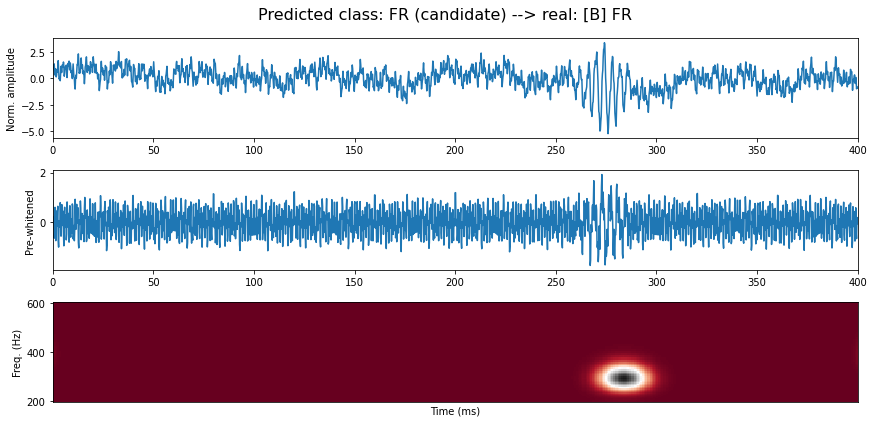





Event 15 meta data
-------------------
ID: 15
type: [B] Spk-FR
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: freq = 250; numcycles = 12; spike_sig x 100; FR_sig x 10
Noise: [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0, 250.0, 425.0, 500.0, 800.0, 1500.0]


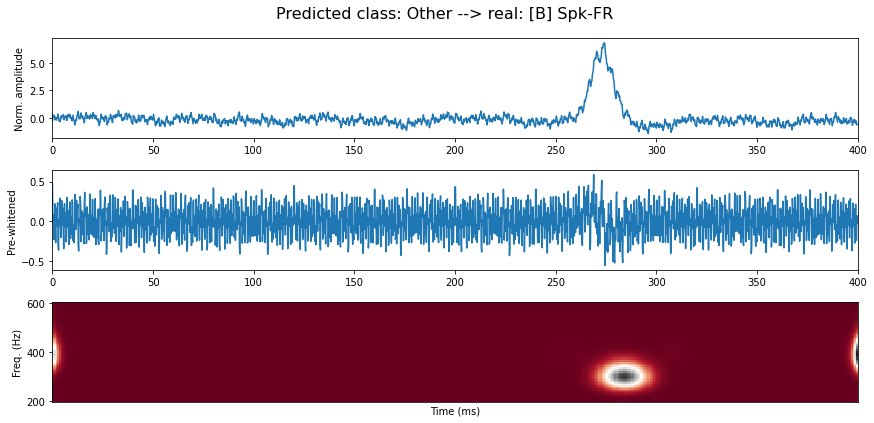





Event 16 meta data
-------------------
ID: 16
type: [C] Spk-alone
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: simul:1000; spike_sig x 100
Noise: [2.5, 6.0, 10.0, 16.0, 32.5, 67.5, 165.0, 250.0, 425.0, 500.0, 800.0, 1500.0]


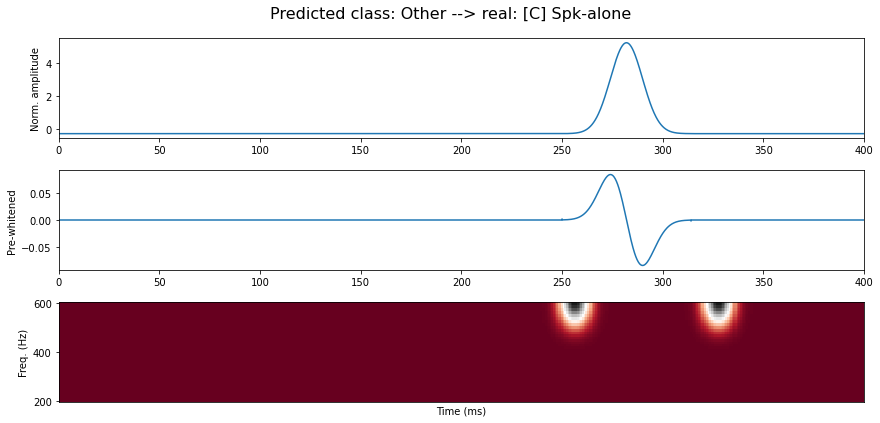





Event 17 meta data
-------------------
ID: 17
type: [D] Spk-alone
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: simul:1000; spike_sig x 100
Noise: random.uniform(-5,5)


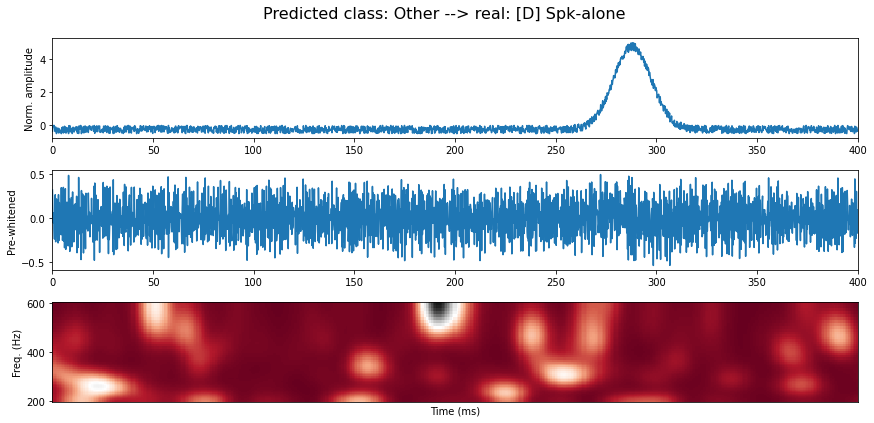





Event 18 meta data
-------------------
ID: 18
type: [D] FR
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: freq = 250; numcycles = 12; spike_sig x 100; FR_sig x 10
Noise: random.uniform(-5,5)


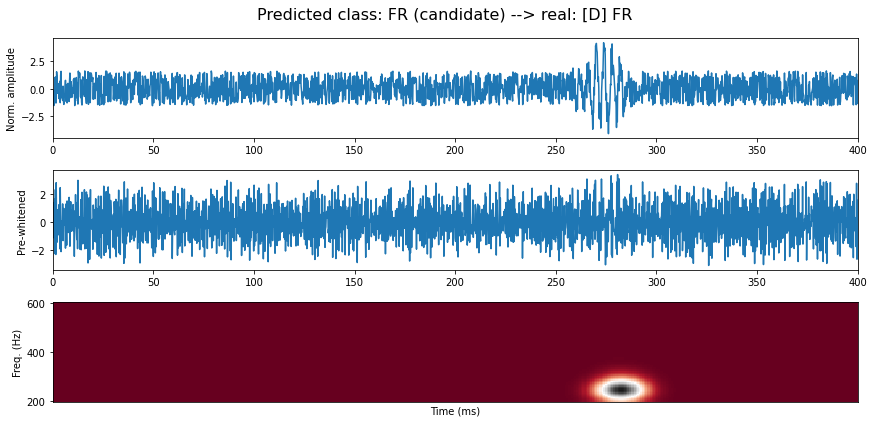





Event 19 meta data
-------------------
ID: 19
type: [D] Spk-FR
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: freq = 250; numcycles = 12; spike_sig x 100; FR_sig x 10
Noise: random.uniform(-5,5)


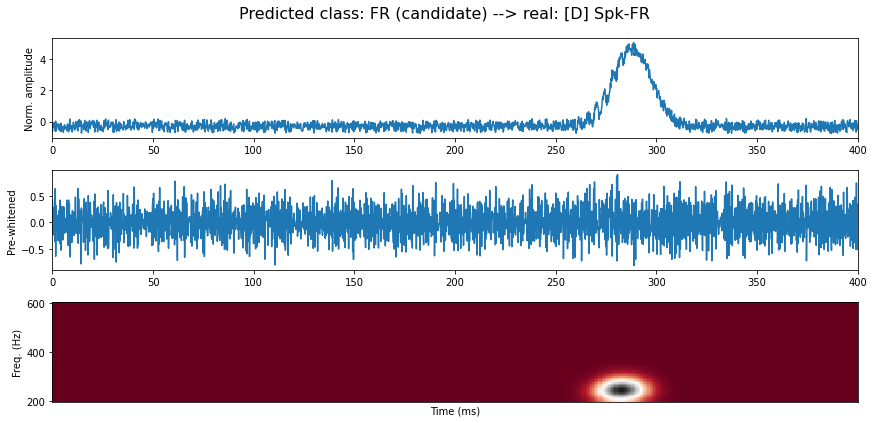





Event 20 meta data
-------------------
ID: 20
type: [E] Spk-alone
patient_num: 999
chan_type: micro
chan_name: simul
sampling_frequency: 5000
eventTime_inFilename_(s): 0.0
event_duration_(s): 0.0
extracted_signal_duration_(ms): 400.0
scale_unit: uV
filename: 
eventOnset_inDatabase_(ms): None
eventEnd_inDatabase_(ms): None
Detection_predictions: [0.0, 0.0]
predicted_type: Test
Note: simul:1000; spike_sig x 100
Noise: random.uniform(-5,5)


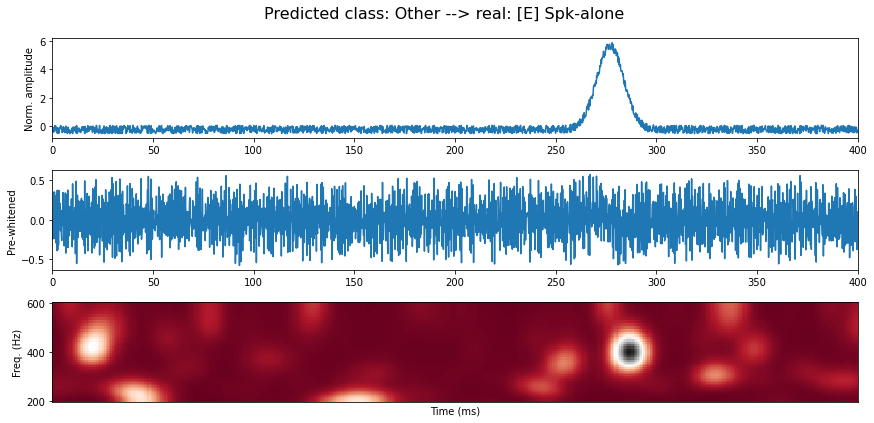

In [14]:
### List all files (timeseries) in folder
file_names_in_folder = os.listdir(os.path.join(events_folderpath, "test_events_database/events_signal_data"))
file_names = [fname for fname in file_names_in_folder if ".txt" in fname]
print(file_names)
print("")

### Load meta-data
json_filepath = os.path.join(events_folderpath, "test_events_database/events_info.json")
json_dict = json.load(open(json_filepath)) 

### Loop over all events of a given category (ex: macro-FR or micro-nonFR)
for event_num in range(0,len(json_dict["events_info"])):

    ### Get event file name                      
    current_sfreq = json_dict["events_info"][event_num]["sampling_frequency"]
    file_name_to_plot = f"event_{json_dict['events_info'][event_num]['ID']}.txt"

    ### Load one timeseries
    timeseries_filepath = os.path.join(events_folderpath, f"test_events_database/events_signal_data/{file_name_to_plot}")
    timeseries = load_one_timeseries(timeseries_filepath)

    ### Standardize timeseries
    standardized_timeseries = standardize_timeseries(timeseries)

    ### Whiten timeseries
    whitened_timeseries = whiten_timeseries(standardized_timeseries)

    ### Create, whiten and convolve scalogram
    scalogram = Calc_scalogram(
        whitened_timeseries, bp_filter, current_sfreq, nf=50, 
        whiten_ZH0=True, apply_convolution=True)

    ### Because most of the events in this database were simulated, the edges of the scalograms
    ##- are artefacted. For this reason, it is necessary to crop the edges.
    scalogram.scalogram_dict["scalogram"] = scalogram.scalogram_dict["scalogram"][:,25:-25]
    #scalogram.scalogram_dict["x_cwt"] = scalogram.scalogram_dict["x_cwt"][:,20:-20]
    #scalogram.scalogram_dict["y_cwt"] = scalogram.scalogram_dict["y_cwt"][:,20:-20]
    scalogram.scalogram_dict["scalogram"] = cv2.resize(scalogram.scalogram_dict["scalogram"], dsize=(500,50), interpolation=cv2.INTER_NEAREST)

    ### Predict scalogram
    pred, pred_class = predict_one_scalogram(model,
        scalogram.scalogram_dict["scalogram"])

    print(f"Event {event_num+1} meta data")
    print("-------------------")
    for key in json_dict['events_info'][event_num]:
        print(f"{key}: {json_dict['events_info'][event_num][key]}")

    plot_one_event(standardized_timeseries, whitened_timeseries, scalogram.scalogram_dict["x_cwt"], scalogram.scalogram_dict["y_cwt"], scalogram.scalogram_dict["scalogram"], f"{pred_class} --> real: {json_dict['events_info'][event_num]['type']}", current_sfreq)

    print("")
    print("")
    print("")
    print("")
